In [37]:

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt


from config import ModelConfig, TrainingConfig, HardwareConfig, DataConfig

import xarray as xr
import torch

import pandas as pd

import os
import glob
import re
import plotly.io as pio

from plotting import Plotting
from visualize_tsne import visualize_tsne

from sklearn.manifold import TSNE

from sklearn.cluster import DBSCAN, KMeans
import hdbscan
from sklearn.neighbors import NearestNeighbors

import seaborn as sns

from VAE_GMM import VAE
from dataset import CustomDataset, DataModule
from torch.utils.data import DataLoader
from sklearn.mixture import GaussianMixture
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib as mpl


mpl.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}"
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 11,      # Schriftgröße Achsenbeschriftung
    "axes.titlesize": 16,      # Schriftgröße Titel
    "axes.linewidth": 0.5,     # Achsenlinienbreite
    "lines.linewidth": 0.5,    # Linienbreite
    "font.size": 11,           # Grundschriftgröße
    "legend.fontsize": 11,     # Legende
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    # tick_direction
    "xtick.direction": "in",
    "ytick.direction": "in",
    #"figure.figsize": (5.7, 3.5),  # z.B. 145mm x 90mm in inch
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,
    "pgf.preamble": "\n".join([
        r"\usepackage[T1]{fontenc}",
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[english]{babel}"
    ]),
})


text_width_mm = 145
inches_per_mm = 1/25.4
fig_width_in = text_width_mm * inches_per_mm
fig_height_in = fig_width_in * 0.6
print('loaded')

SyntaxError: invalid syntax (3672507913.py, line 40)

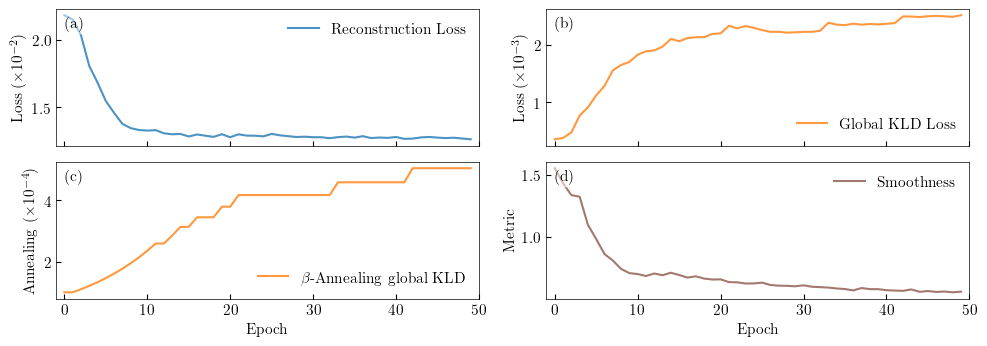

In [2]:
import os
import math
import string
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from tb_utils import load_tensorboard_scalars

# ——— Settings ——————————————————————————————————————————————
base_logs    = "/work/aa0238/a271125/logs/Correct_Normalization"
experiments  = {"Experiment_1": [1]}
#loss_tags    = [
#    "annealing/vae_factor",
#    "val/loss/recon",
#    "val/loss/global_kld",
#    "val/metric/smoothness"
#]

loss_tags    = [
    "val/loss/recon",
    "val/loss/global_kld",
    "annealing/vae_factor",
    "val/metric/smoothness"
]
epoch_length = 43

fig_width_in, fig_height_in = 10, 6  # Set your figure size here
# ——————————————————————————————————————————————————————————————————

# ——— Mapping für Labels, Farben, Y-Achsen-Beschriftungen ————————
tag2label = {
    "annealing/vae_factor":       r'$\beta$-Annealing\ global\ KLD',
    "val/loss/recon":             "Reconstruction Loss",
    "val/loss/global_kld":        "Global KLD Loss",
    "val/metric/smoothness":      "Smoothness",
}
tag2color = {
    "annealing/vae_factor":       "C1",
    "val/loss/recon":             "C0",
    "val/loss/global_kld":        "C1",
    "val/metric/smoothness":      "C5",
}
tag2ylabel = {
    "annealing/vae_factor":       'Annealing',#r'$\beta$-gl.\,KLD',
    "val/loss/recon":             'Loss',
    "val/loss/global_kld":        'Loss',
    "val/metric/smoothness":      'Metric',
}
# ——————————————————————————————————————————————————————————————————

# Subplot‐Grid
n_cols    = 2
n_tags    = len(loss_tags)
n_rows    = math.ceil(n_tags / n_cols)
fig, axes = plt.subplots(n_rows, n_cols,
                         sharex=True,
                         figsize=(fig_width_in, fig_height_in*0.6))
axes_flat = axes.flatten()

# Erzeuge Label-Tokens "(a)", "(b)", ...
subplot_labels = [f"({c})" for c in string.ascii_lowercase]

for idx, tag in enumerate(loss_tags):
    ax = axes_flat[idx]
    ax.text(
        0.02, 0.95, subplot_labels[idx],
        transform=ax.transAxes,
        fontsize='medium', fontweight='bold',
        va='top', ha='left',
        bbox=dict(
            boxstyle="round,pad=0.18",
            fc="white", ec="white", lw=0.8, alpha=0.5
        ),
        zorder=12
    )

    # 1) Alle Daten sammeln und maximalen Absolutwert finden
    all_data = []
    for exp_name, vers in experiments.items():
        for v in vers:
            logdir = os.path.join(base_logs, exp_name, f"version_{v}")
            steps, vals, epochs = load_tensorboard_scalars(
                logdir, tag,
                epoch_length=epoch_length,
                offset=None
            )
            x = epochs if (epochs is not None) else np.array(steps)
            y = np.array(vals)
            mask = (x < 50) & np.isfinite(y)
            if mask.any():
                all_data.append((exp_name, x[mask], y[mask]))
    if not all_data:
        ax.set_visible(False)
        continue

    # 2) Exponenten basierend auf max. Absolutwert ermitteln
    y_abs_max = max(np.max(np.abs(y_arr)) for _, _, y_arr in all_data)
    exp10 = int(math.floor(math.log10(y_abs_max))) if y_abs_max > 0 else 0

    # 3) Formatter konfigurieren
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.offsetText.set_visible(False)
    
    # 4) Daten skaliert plotten (Label und Farbe gemappt)
    for exp_name, x_arr, y_arr in all_data:
        if tag == "val/metric/smoothness":
            y_arr *= -1
        ax.plot(
            x_arr, y_arr / 10**exp10,
            label=tag2label.get(tag, tag),
            color=tag2color.get(tag, None),
            linewidth=1.5,
            alpha=0.8
        )

    ax.set_xlim(-1, 50)

    # 5) Y-Achsenbeschriftung gemappt
    base_label = tag2ylabel.get(tag, tag)
    if exp10 != 0:
        ylabel = rf'{base_label} ($\times 10^{{{exp10}}}$)'
    else:
        ylabel = base_label
    ax.set_ylabel(ylabel)

    if idx // n_cols == n_rows - 1:
        ax.set_xlabel("Epoch")

    # Legende nur für das erste Panel
    if idx in [2]:
        ax.legend(loc='lower right', frameon=False)
    else:
        ax.legend(frameon=False)

# Leere Plätze ausblenden
for j in range(n_tags, n_rows * n_cols):
    axes_flat[j].set_visible(False)

plt.tight_layout()
plt.savefig('./plots/pretrain_loss.pdf', bbox_inches='tight')
plt.show()


/tmp/ipykernel_722510/51519279.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


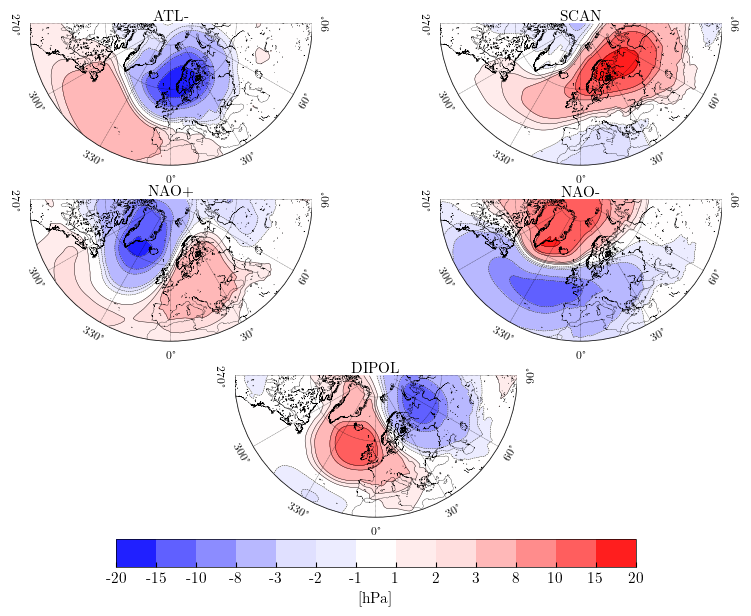

In [6]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(fig_width_in, fig_width_in*0.8))

axA = fig.add_axes([0.11, 0.70, 0.29, 0.18])
axB = fig.add_axes([0.52, 0.70, 0.29, 0.18])

axC = fig.add_axes([0.11, 0.48, 0.29, 0.18])
axD = fig.add_axes([0.52, 0.48, 0.29, 0.18])

axE = fig.add_axes([0.315, 0.26, 0.29, 0.18])
# Colorbar darunter – jetzt 0.52 breit (statt z.B. 0.44)
cax = fig.add_axes([0.20, 0.20, 0.52, 0.035])




axs = [axA, axB, axC, axD, axE]

## Jetzt kannst du wie gehabt plotten:
#fig, axs, cf_handles, cb = cloader.plot_composition(
#    cloader.vae_composition,
#    fig=fig,
#    axes=axs,
#    #titles=["(a)", "(b)", "(c)", "(d)", "(e)"],
#    show_colorbar=False
#)

fig, axs, cf_handles, cb = cloader.plot_composition(cloader.kmeans_composition, fig=fig, axes=axs, show_colorbar=False)


plt.subplots_adjust(wspace=0.08, hspace=0.12, bottom=0.08, top=0.97, left=0.06, right=0.98)


cb = fig.colorbar(
    cf_handles[0],
    cax=cax,
    orientation='horizontal',
    extend='both',
    aspect=30
)

cb.set_label('[hPa]', fontsize = 11)
cb.set_ticks(cloader.plotter.levels)
cb.set_ticklabels([str(lvl) for lvl in cloader.plotter.levels])

cb.ax.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig(f'./plots/Regimes.pdf', bbox_inches='tight')

plt.show()


Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hungarian-Algorithmus gesetzt.


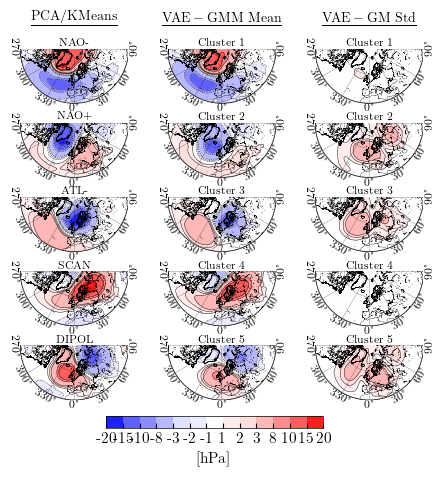

In [7]:
from loaders import ClusteringLoader
from matplotlib.gridspec import GridSpec

def add_column_titles(fig, axs, titles, ypos=0.93, fontsize=10):
    """
    Fügt Spaltentitel zentriert über jeder Spalte hinzu.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
        Die Figure, zu der die Titel hinzugefügt werden sollen.
    axs : numpy.ndarray
        2D Array der Achsen-Objekte, [Zeile, Spalte].
    titles : list of str
        Liste der Spaltentitel.
    ypos : float, optional
        Y-Position im Figure-Koordinatensystem (0=unten, 1=oben).
    fontsize : int, optional
        Schriftgröße der Titel.
    """
    ncols = axs.shape[1]
    assert len(titles) == ncols, "Number of titles must match number of columns"
    for j, title in enumerate(titles):
        ax = axs[0, j]
        pos = ax.get_position()
        xpos = pos.x0 + 0.5 * (pos.x1 - pos.x0)
        fig.text(xpos, ypos, title, ha='center', va='bottom', fontsize=fontsize)
    
NETCDF = '/home/a/a271125/work/data/slp.N_djfm_6h_aac_detrend_1deg_north_atlantic.nc'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cloader = ClusteringLoader(
    log_dir      = '/work/aa0238/a271125/logs/Correct_Normalization',#StableVAE',
    experiment   = 'Experiment_4',#'NewNormalization',
    version      = 10,
    nc_path      = NETCDF,
    device       = device
)
    
n_cols  = 3  
fig = plt.figure(figsize=(fig_width_in, fig_width_in*0.8))
gs = GridSpec(5, n_cols, wspace=0, hspace=0.35)  # Hier kannst du noch feiner justieren
axs = np.array([[fig.add_subplot(gs[i, j]) for j in range(n_cols)] for i in range(5)])

plotter = cloader.plotter

patterns_xr =xr.open_dataarray("all_patterns_neu.nc")
pattern_mean = patterns_xr.mean(dim='version')
pattern_std = patterns_xr.std(dim='version')

cloader.regime_order = ["NAO-", "NAO+", "ATL-", "SCAN", "DIPOL"]
cf_handles_0 = cloader.plot_composition(cloader.kmeans_composition, fig=fig, axes=axs[:, 0], show_colorbar=False)[2]

cf_handles_1 = plotter.plot_isolines(pattern_mean, fig=fig, axes=axs[:, 1], show_colorbar=False)[2]
cf_handles_2 = plotter.plot_isolines(pattern_std, fig=fig, axes=axs[:, 2], show_colorbar=False)[2]



#fig.subplots_adjust(
#    left=0.13,   
#    right=0.87,  
#    top=0.94,     
#    bottom=0.1,  
#    wspace=0.25, 
#    hspace=0.35,  
#)



#column_titles = ["VAE GMM", "KMeans"]
column_titles = [ r"$\underline{\mathrm{PCA/KMeans}}$", r"$\underline{\mathrm{VAE-GMM~Mean}}$", r"$\underline{\mathrm{VAE-GM~Std}}$",]
# Dann wie gehabt in der Schleife

add_column_titles(fig, axs, column_titles, ypos=0.93, fontsize=10)

orig_left = 0.12
orig_width = 0.76
shrink_factor = 0.5
new_width = orig_width * shrink_factor
new_left = orig_left + 0.5 * (orig_width - new_width)
cbar_ax = fig.add_axes([new_left, 0.05, new_width, 0.025])


# Colorbar hinzufügen, horizontal
cb = fig.colorbar(cf_handles_0[0], cax=cbar_ax, orientation='horizontal', label='[hPa]')
cb.set_ticks(cloader.plotter.levels)  # Optional: eigene Levels
cb.set_ticklabels([str(lvl) for lvl in cloader.plotter.levels])
#fig.tight_layout()
plt.savefig(f'./plots/compositions.pdf', bbox_inches='tight')
plt.show()

Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hungarian-Algorithmus gesetzt.


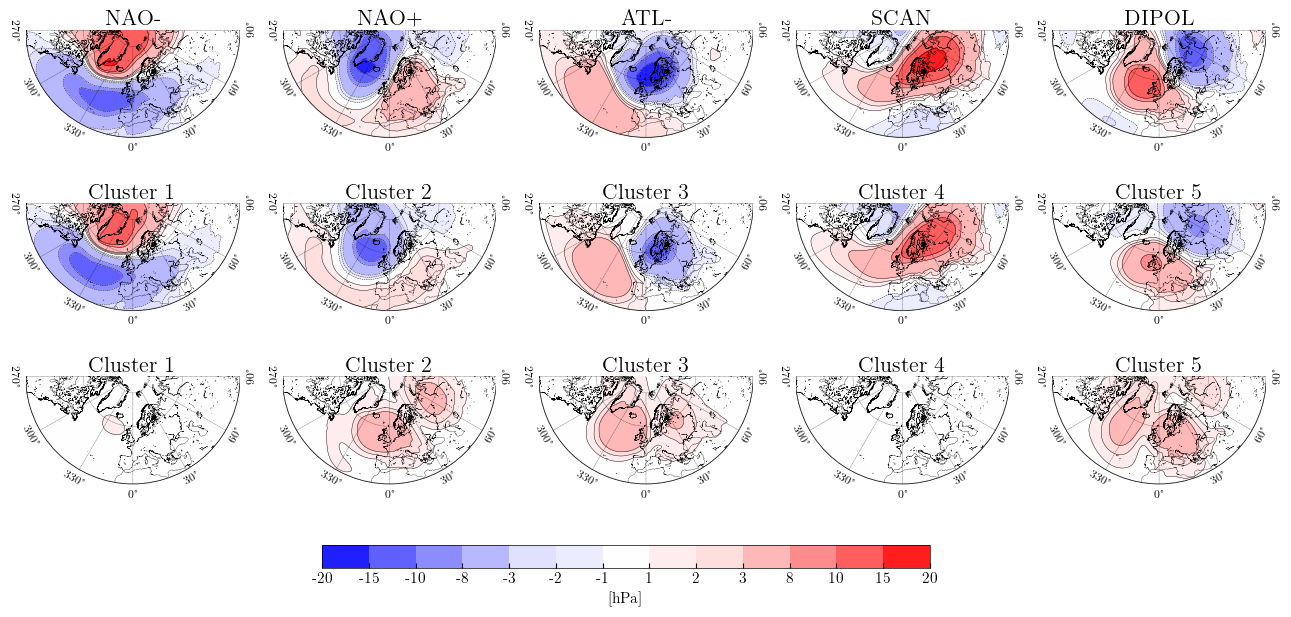

In [40]:
from loaders import ClusteringLoader
from matplotlib.gridspec import GridSpec

def add_column_titles(fig, axs, titles, ypos=0.93, fontsize=10):
    """
    Wie gehabt – falls du weiterhin Spaltentitel über den 5 Regimen möchtest.
    """
    ncols = axs.shape[1]
    assert len(titles) == ncols, "Number of titles must match number of columns"
    for j, title in enumerate(titles):
        ax = axs[0, j]
        pos = ax.get_position()
        xpos = pos.x0 + 0.5 * (pos.x1 - pos.x0)
        fig.text(xpos, ypos, title, ha='center', va='bottom', fontsize=fontsize)

from matplotlib.lines import Line2D  # <-- wichtig

def add_row_titles(fig, axs, titles, xpos=0.01, fontsize=16, va='center'):
    """
    Setzt zentrierte Zeilentitel links vom Grid, unterstützt \n für zwei Zeilen
    und zeichnet eine Unterstreichung als Linie (ohne LaTeX).
    """
    nrows = axs.shape[0]
    assert len(titles) == nrows, "Number of titles must match number of rows"

    for i, title in enumerate(titles):
        ax = axs[i, 0]
        pos = ax.get_position()
        yc  = pos.y0 + 0.5 * (pos.y1 - pos.y0)

        # Titeltext (Unicode-Strich ist ok)
        fig.text(
            xpos, yc, title,
            ha='center', va=va, fontsize=fontsize, family='serif'
        )

        # Unterstreichung: Breite heuristisch aus längster Zeile ableiten
        longest = max(title.split("\n"), key=len)
        L = max(0.06, min(0.20, 0.008 * len(longest)))  # 6–20% der Figure-Breite

        # Vertikaler Offset: bei 2 Zeilen etwas tiefer
        y_off = 0.022 if "\n" in title else 0.014
        x0, x1, y = xpos - L/2, xpos + L/2, yc - y_off

        # Linie als Artist auf Figure-Ebene
        fig.add_artist(Line2D([x0, x1], [y, y], transform=fig.transFigure, lw=1.0))


NETCDF = '/home/a/a271125/work/data/slp.N_djfm_6h_aac_detrend_1deg_north_atlantic.nc'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cloader = ClusteringLoader(
    log_dir      = '/work/aa0238/a271125/logs/Correct_Normalization',
    experiment   = 'Experiment_4',
    version      = 10,
    nc_path      = NETCDF,
    device       = device
)

# --- WICHTIG: echtes Transponieren des Grids ---
n_cols  = 3                               # vorher Spaltenzahl -> jetzt Zeilenzahl
n_regimes = 5                             # vorher Zeilenzahl -> jetzt Spaltenzahl
fig = plt.figure(figsize=(16,9))#fig_width_in, fig_width_in*0.8))
gs = GridSpec(n_cols, n_regimes, wspace=0.2, hspace=-0.5)

# axs hat nun Form (3, 5): 3 Zeilen (deine drei „Methoden“), 5 Spalten (Regime)
axs = np.array([[fig.add_subplot(gs[i, j]) for j in range(n_regimes)] for i in range(n_cols)])

plotter = cloader.plotter

patterns_xr = xr.open_dataarray("all_patterns_neu.nc")
pattern_mean = patterns_xr.mean(dim='version')
pattern_std  = patterns_xr.std(dim='version')

cloader.regime_order = ["NAO-", "NAO+", "ATL-", "SCAN", "DIPOL"]

# --- ACHTUNG: jetzt je ZEILE plotten ---
# Zeile 0: KMeans-Kompositionen
cf_handles_0 = cloader.plot_composition(
    cloader.kmeans_composition, fig=fig, axes=axs[0, :], show_colorbar=False
)[2]

# Zeile 1: VAE-GMM Mean
cf_handles_1 = plotter.plot_isolines(
    pattern_mean, fig=fig, axes=axs[1, :], show_colorbar=False
)[2]

# Zeile 2: VAE-GMM Std
cf_handles_2 = plotter.plot_isolines(
    pattern_std, fig=fig, axes=axs[2, :], show_colorbar=False
)[2]

# --- Titel: Entweder Spalten-ODER Zeilentitel verwenden ---
# 1) Spaltentitel über den 5 Regimen (optional):
#add_column_titles(fig, axs, titles=cloader.regime_order, ypos=0.93, fontsize=10)

# 2) Zeilentitel links (deine bisherigen "Spaltentitel" als Zeilentitel):
#row_titles = [
#    "PCA/KMeans",
#    "VAE–GMM\nMean",
#    "VAE–GMM\nStd",
#]
#
#
#add_row_titles(fig, axs, row_titles, xpos=0.01, fontsize=16)

# Direkt nach dem Plotten
for ax in axs.flatten():
    ax.title.set_fontsize(16)  # oder jede andere pt-Größe


# --- Colorbar unten mittig wie gehabt ---
orig_left  = 0.12
orig_width = 0.76
shrink_factor = 0.5
new_width = orig_width * shrink_factor
new_left  = orig_left + 0.5 * (orig_width - new_width)
cbar_ax = fig.add_axes([new_left, 0.15, new_width, 0.025])

cb = fig.colorbar(cf_handles_0[0], cax=cbar_ax, orientation='horizontal', label='[hPa]')
cb.set_ticks(cloader.plotter.levels)
cb.set_ticklabels([str(lvl) for lvl in cloader.plotter.levels])

plt.savefig('./plots/compositions_transponiert.pdf', bbox_inches='tight')
plt.show()


Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hungarian-Algorithmus gesetzt.
Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hungarian-Algorithmus gesetzt.
Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hungarian-Algorithmus gesetzt.


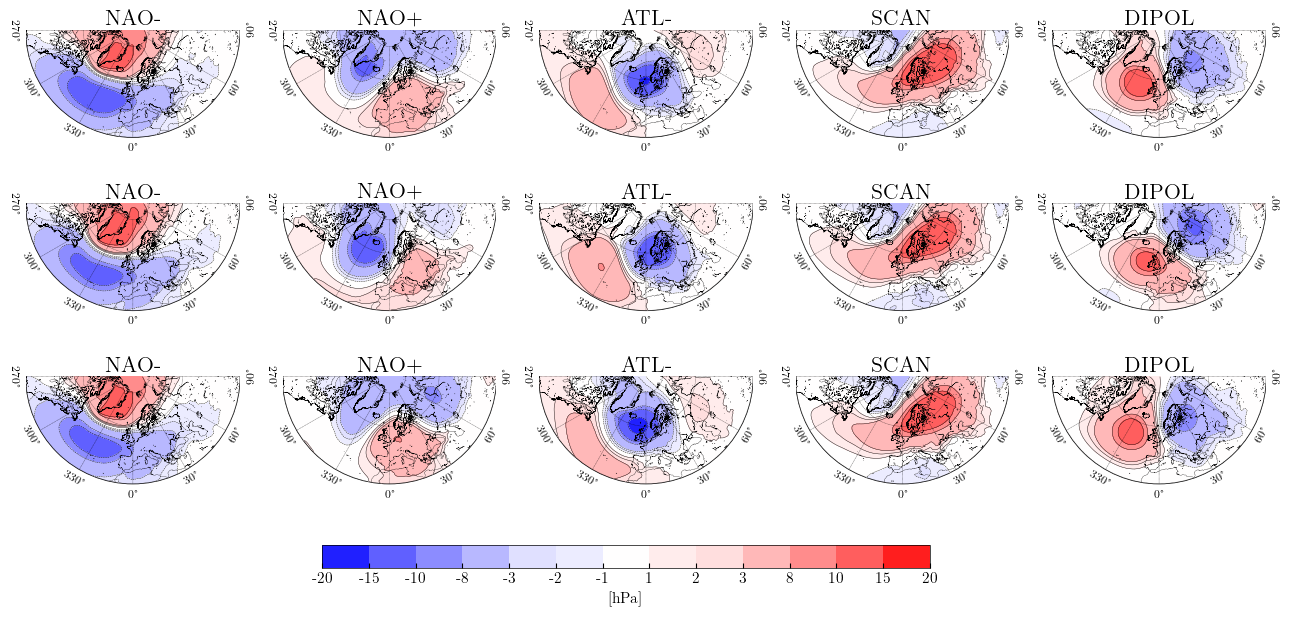

In [62]:
# --- WICHTIG: echtes Transponieren des Grids ---
n_cols  = 3                               # vorher Spaltenzahl -> jetzt Zeilenzahl
n_regimes = 5                             # vorher Zeilenzahl -> jetzt Spaltenzahl
fig = plt.figure(figsize=(16,9))#fig_width_in, fig_width_in*0.8))
gs = GridSpec(n_cols, n_regimes, wspace=0.2, hspace=-0.5)

# axs hat nun Form (3, 5): 3 Zeilen (deine drei „Methoden“), 5 Spalten (Regime)
axs = np.array([[fig.add_subplot(gs[i, j]) for j in range(n_regimes)] for i in range(n_cols)])


NETCDF = '/home/a/a271125/work/data/slp.N_djfm_6h_aac_detrend_1deg_north_atlantic.nc'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cloader_a = ClusteringLoader(
    log_dir    = '/work/aa0238/a271125/logs/Correct_Normalization',
    experiment = 'Experiment_4',
    version    = 29,
    nc_path    = NETCDF,
    device     = device
)
cloader_b = ClusteringLoader(
    log_dir    = '/work/aa0238/a271125/logs/Correct_Normalization',
    experiment = 'Experiment_4',
    version    = 10,
    nc_path    = NETCDF,
    device     = device
)
cloader_c = ClusteringLoader(
    log_dir    = '/work/aa0238/a271125/logs/Correct_Normalization',
    experiment = 'Experiment_4',
    version    = 68,
    nc_path    = NETCDF,
    device     = device
)

# Einheitliche Regime-Reihenfolge (Spalten)
regimes = ["NAO-", "NAO+", "ATL-", "SCAN", "DIPOL"]
cloader_a.regime_order = regimes
cloader_b.regime_order = regimes
cloader_c.regime_order = regimes

# --- ACHTUNG: jetzt je ZEILE plotten ---

# Beispiel: compositions; falls du isolines brauchst, tausche die Aufrufe entsprechend aus.
cf_handles_a = cloader_a.plot_composition(cloader_a.vae_composition, fig=fig, axes=axs[0, :], show_colorbar=False)[2]
cf_handles_b = cloader_b.plot_composition(cloader_b.vae_composition, fig=fig, axes=axs[1, :], show_colorbar=False)[2]
cf_handles_c = cloader_c.plot_composition(cloader_c.vae_composition, fig=fig, axes=axs[2, :], show_colorbar=False)[2]

# Direkt nach dem Plotten
for ax in axs.flatten():
    ax.title.set_fontsize(16)  # oder jede andere pt-Größe


# --- Colorbar unten mittig wie gehabt ---
orig_left  = 0.12
orig_width = 0.76
shrink_factor = 0.5
new_width = orig_width * shrink_factor
new_left  = orig_left + 0.5 * (orig_width - new_width)
cbar_ax = fig.add_axes([new_left, 0.15, new_width, 0.025])

cb = fig.colorbar(cf_handles_0[0], cax=cbar_ax, orientation='horizontal', label='[hPa]')
cb.set_ticks(cloader.plotter.levels)
cb.set_ticklabels([str(lvl) for lvl in cloader.plotter.levels])

# --- Speichern ---

os.makedirs("./plots", exist_ok=True)
plt.savefig('./plots/comparison_ABC_transponiert.pdf', bbox_inches='tight')
plt.show()


Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hungarian-Algorithmus gesetzt.
Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hungarian-Algorithmus gesetzt.
Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hungarian-Algorithmus gesetzt.


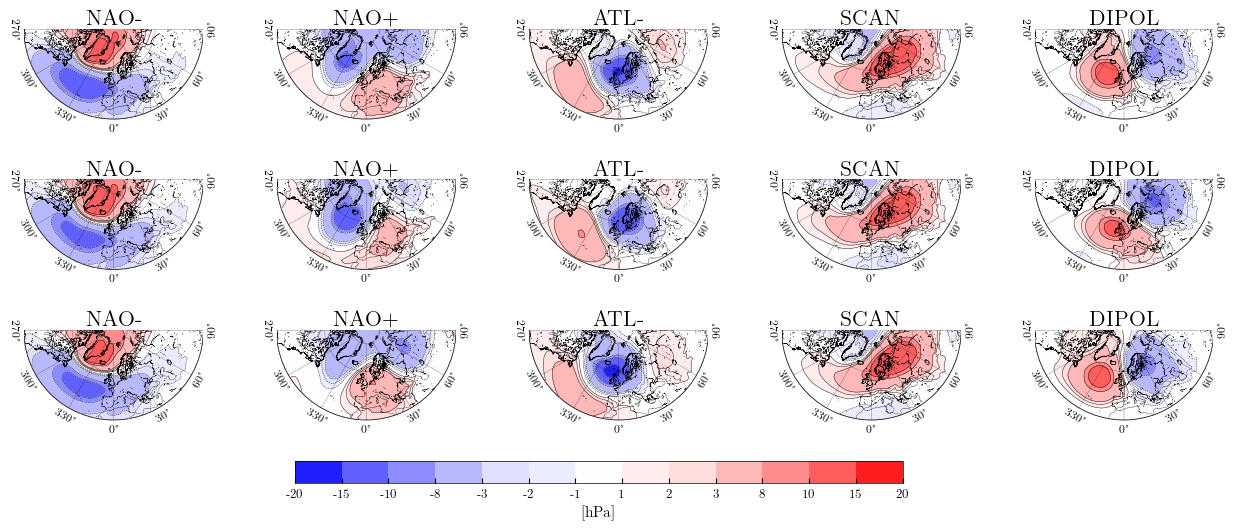

In [58]:
# --- Imports ---
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import xarray as xr

from loaders import ClusteringLoader

# --- Titel-Funktionen ---

def add_column_titles(fig, axs, titles, ypos=0.98, fontsize=10):
    """
    Fügt Spaltentitel zentriert über jeder Spalte hinzu (ohne LaTeX).
    """
    ncols = axs.shape[1]
    assert len(titles) == ncols, "Number of titles must match number of columns"
    for j, title in enumerate(titles):
        ax  = axs[0, j]
        pos = ax.get_position()
        xpos = pos.x0 + 0.5 * (pos.x1 - pos.x0)
        fig.text(xpos, ypos, title, ha='center', va='bottom', fontsize=fontsize, family='serif')

def add_row_titles(fig, axs, titles, xpos=0.01, fontsize=16, va='center', pad_frac=0.008):
    """
    Setzt links vom Grid Zeilentitel (unterstützt \n) und unterstreicht den gesamten Textblock.
    Fallback: bei Fehler nur Text und print().
    """
    nrows = axs.shape[0]
    assert len(titles) == nrows, "Number of titles must match number of rows"

    for i, title in enumerate(titles):
        ax  = axs[i, 0]
        pos = ax.get_position()
        yc  = pos.y0 + 0.5 * (pos.y1 - pos.y0)

        txt = fig.text(xpos, yc, title, ha='center', va=va, fontsize=fontsize, family='serif')

        # Unterstreichung robust anhand echter Textbreite
        try:
            try:
                renderer = fig.canvas.get_renderer()
                if renderer is None:
                    raise RuntimeError("renderer is None")
            except Exception:
                fig.canvas.draw()
                renderer = fig.canvas.get_renderer()

            bbox = txt.get_window_extent(renderer=renderer)  # in Pixeln
            inv  = fig.transFigure.inverted()
            (x0f, y0f) = inv.transform((bbox.x0, bbox.y0))
            (x1f, _  ) = inv.transform((bbox.x1, bbox.y0))

            # Bei Zweizeilern etwas mehr Abstand
            y_line = y0f - (pad_frac * (1.6 if "\n" in title else 1.0))

            fig.add_artist(Line2D([x0f, x1f], [y_line, y_line],
                                  transform=fig.transFigure, lw=1.0))
        except Exception as e:
            print(f"[add_row_titles] underline failed for row {i}: {e}")
            # kein Re-Raise -> weiter ohne Unterstreichung

# --- Daten/Loader ---

NETCDF = '/home/a/a271125/work/data/slp.N_djfm_6h_aac_detrend_1deg_north_atlantic.nc'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cloader_a = ClusteringLoader(
    log_dir    = '/work/aa0238/a271125/logs/Correct_Normalization',
    experiment = 'Experiment_4',
    version    = 29,
    nc_path    = NETCDF,
    device     = device
)
cloader_b = ClusteringLoader(
    log_dir    = '/work/aa0238/a271125/logs/Correct_Normalization',
    experiment = 'Experiment_4',
    version    = 10,
    nc_path    = NETCDF,
    device     = device
)
cloader_c = ClusteringLoader(
    log_dir    = '/work/aa0238/a271125/logs/Correct_Normalization',
    experiment = 'Experiment_4',
    version    = 68,
    nc_path    = NETCDF,
    device     = device
)

# Einheitliche Regime-Reihenfolge (Spalten)
regimes = ["NAO-", "NAO+", "ATL-", "SCAN", "DIPOL"]
cloader_a.regime_order = regimes
cloader_b.regime_order = regimes
cloader_c.regime_order = regimes

# --- Figure & Grid: 3 Zeilen × 5 Spalten (transponiert) ---

fig_width_in = 16  # ggf. anpassen
n_rows = 3
n_cols = 5

fig = plt.figure(figsize=(16,9))#(fig_width_in, fig_width_in * 0.6))
#gs  = GridSpec(n_rows, n_cols, wspace=0.10, hspace=0.35)
gs = GridSpec(n_cols, n_regimes, wspace=0.1, hspace=0.65)
axs = np.array([[fig.add_subplot(gs[i, j]) for j in range(n_cols)] for i in range(n_rows)])

# --- Plots je ZEILE (Runs) über alle 5 Spalten (Regime) ---

# Beispiel: compositions; falls du isolines brauchst, tausche die Aufrufe entsprechend aus.
cf_handles_a = cloader_a.plot_composition(cloader_a.vae_composition, fig=fig, axes=axs[0, :], show_colorbar=False)[2]
cf_handles_b = cloader_b.plot_composition(cloader_b.vae_composition, fig=fig, axes=axs[1, :], show_colorbar=False)[2]
cf_handles_c = cloader_c.plot_composition(cloader_c.vae_composition, fig=fig, axes=axs[2, :], show_colorbar=False)[2]

# --- Layout-Feintuning: Platz für Titel oben & Colorbar unten ---

# Direkt nach dem Plotten
for ax in axs.flatten():
    ax.title.set_fontsize(16)  # oder jede andere pt-Größe


#fig.subplots_adjust(
#    left=0.08,
#    right=0.98,
#    top=0.92,     # Platz für Spaltentitel
#    bottom=0.12,  # Platz für Colorbar
#    wspace=0.25,  # horizontaler Abstand (überschreibt wspace aus GridSpec)
#    hspace=0.35
#)
#
# --- Spalten- & Zeilentitel ---

# Spalten = Regime
#add_column_titles(fig, axs, regimes, ypos=0.96, fontsize=11)

# Zeilen = Runs A/B/C (mit Unterstreichung, ohne LaTeX)
#row_titles = ["Run (A)", "Run (B)", "Run (C)"]
#add_row_titles(fig, axs, row_titles, xpos=0.02, fontsize=14)

# --- Zentrale Colorbar unten ---
orig_left  = 0.12
orig_width = 0.76
shrink_factor = 0.5
new_width = orig_width * shrink_factor
new_left  = orig_left + 0.5 * (orig_width - new_width)
cbar_ax = fig.add_axes([new_left, 0.375, new_width, 0.025])

# Nimm die Levels von einem der Plotter (identisch angenommen)
cb = fig.colorbar(cf_handles_a[0], cax=cbar_ax, orientation='horizontal', label='[hPa]')
cb.set_ticks(cloader_a.plotter.levels)
cb.set_ticklabels([str(l) for l in cloader_a.plotter.levels], fontsize=9)

# --- Speichern ---

os.makedirs("./plots", exist_ok=True)
plt.savefig('./plots/comparison_ABC_transponiert.pdf', bbox_inches='tight')
plt.show()


Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hungarian-Algorithmus gesetzt.
Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hungarian-Algorithmus gesetzt.
Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hungarian-Algorithmus gesetzt.


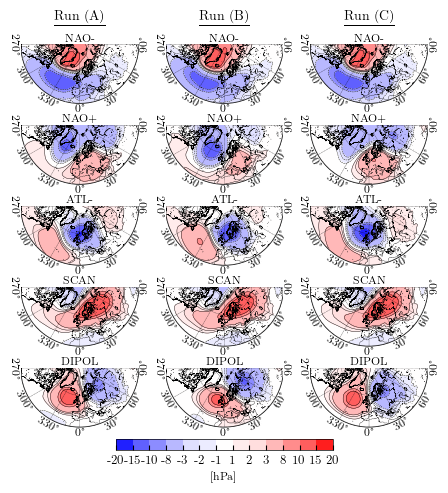

In [10]:
from loaders import ClusteringLoader
from matplotlib.gridspec import GridSpec

def add_column_titles(fig, axs, titles, ypos=0.93, fontsize=10):
    """
    Fügt Spaltentitel zentriert über jeder Spalte hinzu.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
        Die Figure, zu der die Titel hinzugefügt werden sollen.
    axs : numpy.ndarray
        2D Array der Achsen-Objekte, [Zeile, Spalte].
    titles : list of str
        Liste der Spaltentitel.
    ypos : float, optional
        Y-Position im Figure-Koordinatensystem (0=unten, 1=oben).
    fontsize : int, optional
        Schriftgröße der Titel.
    """
    ncols = axs.shape[1]
    assert len(titles) == ncols, "Number of titles must match number of columns"
    for j, title in enumerate(titles):
        ax = axs[0, j]
        pos = ax.get_position()
        xpos = pos.x0 + 0.5 * (pos.x1 - pos.x0)
        fig.text(xpos, ypos, title, ha='center', va='bottom', fontsize=fontsize)
        
NETCDF='/home/a/a271125/work/data/slp.N_djfm_6h_aac_detrend_1deg_north_atlantic.nc'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


cloader_a = ClusteringLoader(
        log_dir      = '/work/aa0238/a271125/logs/Correct_Normalization',#StableVAE',
        experiment   = 'Experiment_4',#'NewNormalization',
        version      = 29,
        nc_path      = NETCDF,
        device       = device
    )

cloader_b = ClusteringLoader(
        log_dir      = '/work/aa0238/a271125/logs/Correct_Normalization',#StableVAE',
        experiment   = 'Experiment_4',#'NewNormalization',
        version      = 10,
        nc_path      = NETCDF,
        device       = device
    )
       
cloader_c = ClusteringLoader(
        log_dir      = '/work/aa0238/a271125/logs/Correct_Normalization',#StableVAE',
        experiment   = 'Experiment_4',#'NewNormalization',
        version      = 68,
        nc_path      = NETCDF,
        device       = device
    )
num_col = 3
fig = plt.figure(figsize=(fig_width_in, fig_width_in*0.8))
gs = GridSpec(5, num_col,
              wspace=0,       # wie im 2. Beispiel
              hspace=0.35) 
axs = np.array([[fig.add_subplot(gs[i, j]) for j in range(num_col)] for i in range(5)])


cloader_a.regime_order = ["NAO-", "NAO+", "ATL-", "SCAN", "DIPOL"]
cloader_b.regime_order = ["NAO-", "NAO+", "ATL-", "SCAN", "DIPOL"]
cloader_c.regime_order = ["NAO-", "NAO+", "ATL-", "SCAN", "DIPOL"]

#cf_handles_0 = cloader_a.plotter.plot_isolines(comp_a.sel(cluster=order_a).values, fig=fig, axes=axs[:, 0], show_colorbar=False)[2]
#cf_handles_1 = cloader_b.plotter.plot_isolines(cloader_b.vae_composition, fig=fig, axes=axs[:, 1], show_colorbar=False)[2]
#cf_handles_2 = cloader_c.plotter.plot_isolines(comp_c.sel(cluster=order_c).values, fig=fig, axes=axs[:, 2], show_colorbar=False)[2]

cf_handles_0 = cloader_a.plot_composition(cloader_a.vae_composition, fig=fig, axes=axs[:, 0], show_colorbar=False)[2]
cf_handles_1 = cloader_b.plot_composition(cloader_b.vae_composition, fig=fig, axes=axs[:, 1], show_colorbar=False)[2]
cf_handles_2 = cloader_c.plot_composition(cloader_c.vae_composition, fig=fig, axes=axs[:, 2], show_colorbar=False)[2]

fig.subplots_adjust(
    left=0.12,    # Spielfeld nach links versetzt
    right=0.88,   # Spielfeld nach rechts versetzt
    top=0.94,     # gibt Platz oberhalb der obersten Achse
    bottom=0.10,  # gibt Platz unterhalb für die Colorbar
    wspace=0.25,  # horizontaler Abstand
    hspace=0.35   # vertikaler Abstand
)


column_titles = [r"$\underline{\mathrm{Run~(A)}}$", r"$\underline{\mathrm{Run~(B)}}$", r"$\underline{\mathrm{Run~(C)}}$"]
# Dann wie gehabt in der Schleife

add_column_titles(fig, axs, column_titles, ypos=0.98, fontsize=10)

orig_left    = 0.12
orig_width   = 0.76
shrink_factor= 0.5
new_width    = orig_width * shrink_factor
new_left     = orig_left + 0.5 * (orig_width - new_width)
cbar_ax      = fig.add_axes([new_left, 0.05, new_width, 0.025])

cb = fig.colorbar(cf_handles_0[0],
                  cax=cbar_ax,
                  orientation='horizontal',
                  label='[hPa]')
cb.set_ticks(cloader_a.plotter.levels)
cb.set_ticklabels([str(l) for l in cloader_a.plotter.levels], fontsize=9)

#fig.tight_layout()
plt.savefig(f'./plots/comparison_ABC.pdf', bbox_inches='tight')
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE

def visualize_tsne_matplotlib(
    latent_features,
    cluster_probabilities,
    cluster_names=None,
    cluster_colors=None,
    perplexity=30,
    random_state=42,
    fig=None,
    ax=None,
    figsize=(5, 5),
    legend_kwargs=None,
    s=10,
    add_legend=True,
    **kwargs
):
    # --- t-SNE Reduktion ---
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    tsne_results = tsne.fit_transform(latent_features)

    # --- Clusterzuweisung & Transparenz ---
    probs = np.asarray(cluster_probabilities)
    if probs.ndim == 2:
        assignments = np.argmax(probs, axis=1)
        alphas = np.max(probs, axis=1)
    elif probs.ndim == 1:
        assignments = probs.astype(int)
        alphas = np.ones_like(assignments, dtype=float)
    else:
        raise ValueError("cluster_probabilities muss 1D oder 2D sein.")

    unique_clusters = sorted(np.unique(assignments))

    # --- Labels & Farben ---
    if cluster_names is not None:
        labels = [cluster_names[c] for c in unique_clusters]
    else:
        labels = [str(c) for c in unique_clusters]

    if cluster_colors is not None:
        colors = [cluster_colors[c] for c in unique_clusters]
    else:
        colors = sns.color_palette("Set1_r", n_colors=len(unique_clusters))

    color_map = {c: col for c, col in zip(unique_clusters, colors)}

    # --- Achse ggf. anlegen ---
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # --- Scatterplot ---
    ax.scatter(
        tsne_results[:, 0], tsne_results[:, 1],
        c=[color_map[c] for c in assignments],
        alpha=alphas,
        s=s,
        edgecolor='k',
        rasterized=True,
        linewidths=0.1,
        **kwargs
    )
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")

    # --- Gemeinsame Handles für Legende ---
    handles = [
        Line2D([], [], marker='o', linestyle='',
               markerfacecolor=color_map[c],
               markeredgecolor='k',
               markersize=8,
               label=labels[i])
        for i, c in enumerate(unique_clusters)
    ]

    # --- Optionale Einzellgende ---
    if add_legend:
        leg_args = dict(
            handles=handles,
            labels=labels,
            loc='upper center',
            bbox_to_anchor=(0.5, 1.20),
            ncol=min(len(handles), 4),
            frameon=False,
            fontsize=10
        )
        if legend_kwargs:
            leg_args.update(legend_kwargs)
        ax.legend(**leg_args)

    return fig, ax, handles, labels



## 1) Setup: 3 Zeilen, nur winziger Abstand zwischen ihnen
#fig, axs = plt.subplots(
#    nrows=3, ncols=1,
#    figsize=(fig_width_in, fig_width_in * 3),
#    sharex=True,
#    gridspec_kw={'hspace': 0.04}  # sehr kleiner vertikaler Abstand
#)
#
## 2) Plots zeichnen – erste Achse liefert uns Handles & Labels
#_, _, handles, labels = visualize_tsne_matplotlib(
#    cloader_a.mu, cloader_a.gamma,
#    fig=fig, ax=axs[0],
#    s=15,
#    add_legend=False
#)
#visualize_tsne_matplotlib(cloader_b.mu, cloader_b.gamma, fig=fig, ax=axs[1], s=15, add_legend=False)
#visualize_tsne_matplotlib(cloader_c.mu, cloader_c.gamma, fig=fig, ax=axs[2], s=15, add_legend=False)
#
## 3) Nur in der untersten Achse X‑Ticklabels zeigen
#for ax in axs[:-1]:
#    ax.tick_params(labelbottom=False)
#
## 4) Reserviere *genau* so viel Rand unten, dass die Legende nicht abgeschnitten wird
##    und ziehe die Plots straff zusammen
#fig.subplots_adjust(
#    hspace=0.02,      # noch mal sicherstellen, dass Plots eng beieinander stehen
#    bottom=0.08       # hebt die untere Plot-Grenze ein Stück an (8% des Figur-Hochs)
#)
#
## 5) Gemeinsame Legende knapp unter den Plots platzieren
#fig.legend(
#    handles, labels,
#    loc='lower center',
#    bbox_to_anchor=(0.5, 0.0),  # 1% über dem platzierten bottom-Rand
#    ncol=len(handles),
#    frameon=False,
#    fontsize=10
#)
#
#plt.savefig('./plots/tsne.pdf', bbox_inches='tight')
#plt.show()


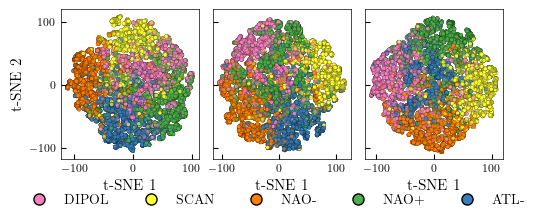

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# 0) Mapping & cluster_names definieren
#    Greife zuerst auf dein Mapping zurück (user_mapping, falls gesetzt, sonst model_to_regime)
mapping = cloader_a.user_mapping or cloader_a.model_to_regime
#    Anzahl der Cluster aus der gamma-Matrix
n_clusters = cloader_a.gamma.shape[1]
#    cluster_names[i] ist der Name für Cluster i
cluster_names = [mapping.get(i, str(i)) for i in range(n_clusters)]

# 1) Subplots mit constrained_layout und quadratischem Aspect
fig, axs = plt.subplots(
    nrows=1, ncols=3,
    figsize=(fig_width_in, fig_width_in * 0.34),
    sharey=True,
    gridspec_kw={'wspace': 0.1}
    #constrained_layout=True,
    #subplot_kw={'aspect': 'equal'}
)

# 2) Drei t‑SNE‑Plots ohne Einzel‑Legende, aber mit cluster_names
_, _, handles, labels = visualize_tsne_matplotlib(
    cloader_a.mu,
    cloader_a.gamma,
    cluster_names=cluster_names,   # <-- hier übergeben
    fig=fig,
    ax=axs[0],
    s=7,
    add_legend=False
)
visualize_tsne_matplotlib(
    cloader_b.mu,
    cloader_b.gamma,
    cluster_names=cluster_names,   # und hier
    fig=fig,
    ax=axs[1],
    s=7,
    add_legend=False
)
visualize_tsne_matplotlib(
    cloader_c.mu,
    cloader_c.gamma,
    cluster_names=cluster_names,   # und hier
    fig=fig,
    ax=axs[2],
    s=7,
    add_legend=False
)

# 3) Y‑Ticklabels in allen bis auf die erste Achse entfernen
for ax in axs[1:]:
    ax.tick_params(labelleft=False)
    ax.set_ylabel('')

# 4) Tick‑Labels drehen, um Überlappung zu vermeiden
for ax in axs:
    plt.setp(ax.get_xticklabels(), rotation=0, ha='center', fontsize=8)
    plt.setp(ax.get_yticklabels(), fontsize=8)

# 5) Gemeinsame Legende mit den gemappten Namen weiter unten platzieren
fig.legend(
    handles, labels,                # "labels" enthält jetzt deine Regime‑Namen
    loc='lower center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=len(handles),
    frameon=False,
    fontsize=10
)

plt.savefig('./plots/tsne_horizontal_mapped.pdf', bbox_inches='tight')
plt.show()


In [48]:
ds.U

<xarray.DataArray 'U' (time: 21296, plev: 1, lat: 90, lon: 360)> Size: 3GB
[689990400 values with dtype=float32]
Coordinates:
  * time     (time) object 170kB 1979-01-01 00:00:00 ... 2022-12-31 18:00:00
  * lon      (lon) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat      (lat) float32 360B 90.0 89.0 88.0 87.0 86.0 ... 5.0 4.0 3.0 2.0 1.0
  * plev     (plev) float64 8B 2.5e+04
Attributes:
    long_name:  U velocity
    units:      m s**-1
    code:       131
    table:      128

In [36]:
mapping_dict = cloader_c.model_to_regime
regime_list = list(mapping_dict.values())

['NAO+', 'NAO-', 'ATL-', 'SCAN', 'DIPOL']


/work/aa0238/a271125/conda/envs/MA/lib/python3.10/site-packages/xarray/backends/file_manager.py:234: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  file.close()
/tmp/ipykernel_3373282/2753854966.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


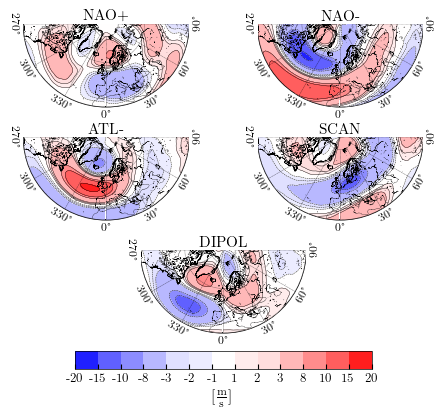

In [47]:
import xarray as xr

ds_u = xr.open_dataset("/work/aa0238/a271050/ERA5/6hr/1grad/u_250.1979-2022.N_djfm_aac_detrend.nc")
#print(ds_u)
var = ds_u["U"][:,0,:,:]


# 2) Wähle, ob du KMeans- oder VAE-Labels verwenden möchtest
labels = cloader_c.vae_labels
mapping_dict = cloader_c.model_to_regime
regime_list = list(mapping_dict.values())

# 4) Zeitkoordinate synchronisieren
times = pd.to_datetime([str(t) for t in var.time.values])
var = var.assign_coords(time=("time", times))

# 5) Auf Länge der Labels beschränken
sel = var.isel(time=slice(0, len(labels)))

# 6) Cluster-Labels als neue Koordinate hinzufügen
sel = sel.assign_coords(cluster=("time", labels))

# 7) Gruppieren und Mittel über die Zeit bilden
comp_u = (
    sel
    .groupby("cluster")
    .mean(dim="time")
    .sortby("cluster")
)

# 8) composition_type setzen (damit plot_composition 
#    die KMeans-Zuordnung nutzt)
comp_u.attrs["composition_type"] = "vae"


# 5. Plotten
plotter = Plotting(
    ds_u.lon, ds_u.lat,
)

fig = plt.figure(figsize=(fig_width_in, fig_width_in*0.9))

axA = fig.add_axes([0.11, 0.70, 0.29, 0.18])
axB = fig.add_axes([0.52, 0.70, 0.29, 0.18])

axC = fig.add_axes([0.11, 0.48, 0.29, 0.18])
axD = fig.add_axes([0.52, 0.48, 0.29, 0.18])

axE = fig.add_axes([0.315, 0.26, 0.29, 0.18])
# Colorbar darunter – jetzt 0.52 breit (statt z.B. 0.44)
cax = fig.add_axes([0.20, 0.20, 0.52, 0.035])

axs = [axA, axB, axC, axD, axE]

fig, axs, cf_handles, cb = plotter.plot_isolines(comp_u, fig=fig, axes=axs, show_colorbar=False, titles = regime_list)


plt.subplots_adjust(wspace=0.08, hspace=0.12, bottom=0.08, top=0.97, left=0.06, right=0.98)


cb = fig.colorbar(
    cf_handles[0],
    cax=cax,
    orientation='horizontal',
    extend='both',
    aspect=30
)

cb.set_label(r'[$\frac{\mathrm{m}}{\mathrm{s}}$]', fontsize = 11)
cb.set_ticks(plotter.levels)
cb.set_ticklabels([str(lvl) for lvl in plotter.levels])

cb.ax.tick_params(labelsize=9)

plt.tight_layout()
plt.savefig(f'./plots/u_winds.pdf', bbox_inches='tight')

/tmp/ipykernel_3373282/335494848.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


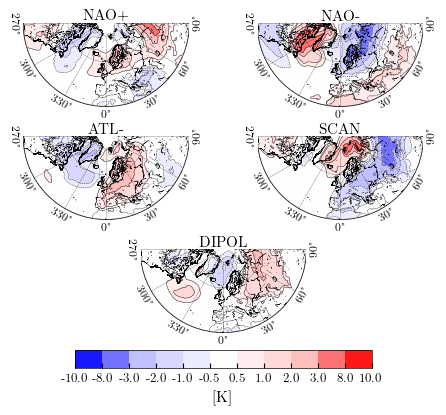

In [45]:
import xarray as xr

ds_t2m = xr.open_dataset('/work/aa0238/a271050/ERA5/6hr/1grad/t2m.1979-2022.N_djfm_aac_detrend.nc')

var = ds_t2m["T2M"]


# 2) Wähle, ob du KMeans- oder VAE-Labels verwenden möchtest
labels = cloader_c.vae_labels
mapping_dict = cloader_c.model_to_regime
regime_list = list(mapping_dict.values())

# 4) Zeitkoordinate synchronisieren
times = pd.to_datetime([str(t) for t in var.time.values])
var = var.assign_coords(time=("time", times))

# 5) Auf Länge der Labels beschränken
sel = var.isel(time=slice(0, len(labels)))

# 6) Cluster-Labels als neue Koordinate hinzufügen
sel = sel.assign_coords(cluster=("time", labels))

# 7) Gruppieren und Mittel über die Zeit bilden
comp_t2m = (
    sel
    .groupby("cluster")
    .mean(dim="time")
    .sortby("cluster")
)

# 8) composition_type setzen (damit plot_composition 
#    die KMeans-Zuordnung nutzt)
comp_t2m.attrs["composition_type"] = "vae"


# 5. Plotten
plotter = Plotting(
    ds_t2m.lon, ds_t2m.lat,
    levels = np.array([-10, -8, -3, -2, -1,-0.5, 0.5, 1, 2, 3, 8, 10]),
    max_scale = 10,
)

fig = plt.figure(figsize=(fig_width_in, fig_width_in*0.9))

axA = fig.add_axes([0.11, 0.70, 0.29, 0.18])
axB = fig.add_axes([0.52, 0.70, 0.29, 0.18])

axC = fig.add_axes([0.11, 0.48, 0.29, 0.18])
axD = fig.add_axes([0.52, 0.48, 0.29, 0.18])

axE = fig.add_axes([0.315, 0.26, 0.29, 0.18])
# Colorbar darunter – jetzt 0.52 breit (statt z.B. 0.44)
cax = fig.add_axes([0.20, 0.20, 0.52, 0.035])

axs = [axA, axB, axC, axD, axE]

fig, axs, cf_handles, cb = plotter.plot_isolines(comp_t2m, fig=fig, axes=axs, show_colorbar=False, titles = regime_list)


plt.subplots_adjust(wspace=0.08, hspace=0.12, bottom=0.08, top=0.97, left=0.06, right=0.98)


cb = fig.colorbar(
    cf_handles[0],
    cax=cax,
    orientation='horizontal',
    extend='both',
    aspect=30
)

cb.set_label('[K]', fontsize = 11)
cb.set_ticks(plotter.levels)
cb.set_ticklabels([str(lvl) for lvl in plotter.levels])

cb.ax.tick_params(labelsize=9)

plt.tight_layout()
plt.savefig(f'./plots/t2m_1.pdf', bbox_inches='tight')

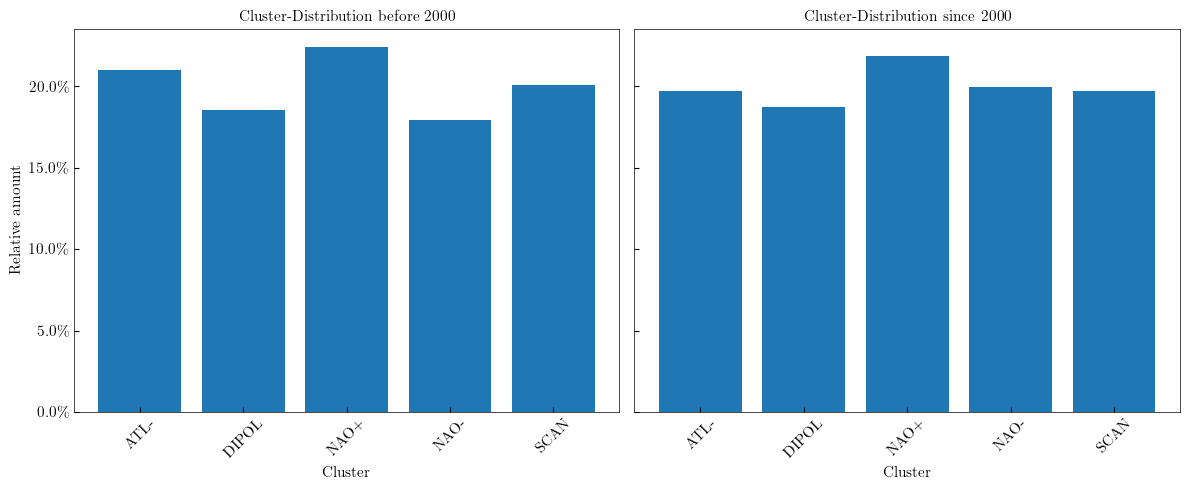

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# 1) Series mit Zeitstempel und Regime-Namen
if getattr(cloader_c, 'named_labels', None) is None:
    mapping = cloader_c.model_to_regime or cloader_c.km_to_regime
    names = [mapping[int(l)] for l in cloader_c.vae_labels]
else:
    names = cloader_c.named_labels.tolist()
series = pd.Series(names, index=cloader_c.times)

# 2) Aufteilen in vor / nach dem Jahr 2000
split = pd.Timestamp("2000-01-01")
before = series[series.index < split]
after  = series[series.index >= split]

# 3) Relative Häufigkeiten errechnen
clusters = sorted(set(series))
rel_before = before.value_counts(normalize=True).reindex(clusters, fill_value=0)
rel_after  = after.value_counts(normalize=True).reindex(clusters, fill_value=0)

# 4) Figure mit 2 Subplots nebeneinander
fig, (ax1, ax2) = plt.subplots(
    ncols=2, figsize=(12, 5), sharey=True
)

# 5) Plot für vor 2000
ax1.bar(clusters, rel_before.values)
ax1.set_title("Cluster-Distribution before 2000")
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Relative amount")
ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
ax1.tick_params(axis='x', rotation=45)

# 6) Plot für seit 2000
ax2.bar(clusters, rel_after.values)
ax2.set_title("Cluster-Distribution since 2000")
ax2.set_xlabel("Cluster")
ax2.tick_params(axis='x', rotation=45)

# 7) Layout und anzeigen
fig.tight_layout()
plt.show()


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from matplotlib.ticker import FormatStrFormatter

# --- 1) Cluster‐Timeseries vorbereiten ---
times = cloader_c.times

# VAE‐Regime‐Namen
if getattr(cloader_c, 'named_labels', None) is not None:
    names_vae = cloader_c.named_labels.tolist()
else:
    names_vae = [cloader_c.model_to_regime[int(l)] for l in cloader_c.vae_labels]
series_vae = pd.Series(names_vae, index=times)

# KMeans‐Regime‐Namen
km_map    = cloader_c.km_to_regime
names_km  = [km_map[int(l)] for l in cloader_c.kmeans_labels]
series_km = pd.Series(names_km, index=times)

# Gemeinsame Cluster‐Reihenfolge
clusters = sorted(set(names_vae))

# --- 2) Jährliche Häufigkeiten berechnen (in %) ---
def annual_freq(series):
    df = series.to_frame('cluster')
    df['year'] = df.index.year
    years = sorted(df['year'].unique())
    freqs = {cl: [] for cl in clusters}
    for y in years:
        grp = df[df['year'] == y]
        total = len(grp)
        for cl in clusters:
            freqs[cl].append((grp['cluster'] == cl).sum() / total * 100)
    return freqs

freqs_vae = annual_freq(series_vae)
freqs_km  = annual_freq(series_km)

# 3) Baseline (nur noch zum Anschauen) und echte before/after-Arrays
split_year = 2000
ylim = 15
data = {}
for method, freqs in [('VAE', freqs_vae), ('KMeans', freqs_km)]:
    before = {}
    after  = {}
    pvals  = {}
    for cl in clusters:
        arr      = np.array(freqs[cl])         # jährliche Häufigkeiten in %
        years    = np.array(sorted(set(times.year)))
        mask_b   = years < split_year
        mask_a   = years >= split_year

        before[cl] = arr[mask_b]
        after[cl]  = arr[mask_a]

        # Welch’s two-sample t-test:
        _, pvals[cl] = ttest_ind(after[cl], before[cl], equal_var=False, nan_policy='omit')
        print(pvals[cl])
    data[method] = {'before': before, 'after': after, 'pvals': pvals}

# 4) Zeichnen der Boxplots der Anomalie-Verteilung (after−before-Mittel) …
#    aber wir können jetzt auch direkt die raw differences plotten
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
for ax, method in zip((ax1,ax2), ('VAE','KMeans')):
    diffs = [ data[method]['after'][cl] - data[method]['before'][cl].mean()
              for cl in clusters ]
    bp = ax.boxplot(
        diffs, positions=np.arange(len(clusters)), widths=0.6,
        whis=(10,90), patch_artist=True, showfliers=False,
        medianprops=dict(color='darkblue')
    )
    for box in bp['boxes']:
        box.set_facecolor('skyblue'); box.set_edgecolor('black')

    # Sterne bei p<0.05
    for i, cl in enumerate(clusters):
        if data[method]['pvals'][cl] < 0.05:
            y90 = np.percentile(diffs[i], 90)
            ax.text(i, y90 + 0.5, '*', ha='center', va='bottom', fontsize=14)

    ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    ax.set_title(f"({method}) Change in Annual Frequency")
    ax.set_xticks(range(len(clusters)))
    ax.set_xticklabels(clusters, rotation=45, ha='right')
    ax.set_xlabel("Cluster")
    if ax is ax1:
        ax.set_ylabel("Frequency Change [pp]")
    ax.set_ylim(-ylim, ylim)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

fig.tight_layout()
plt.show()

NameError: name 'ttest_ind' is not defined

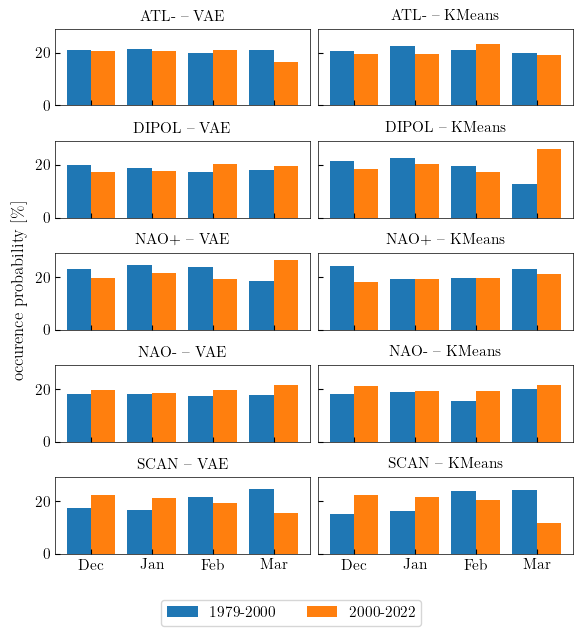

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar


# 1) Serien erstellen
if getattr(cloader_c, 'named_labels', None) is not None:
    names_vae = cloader_c.named_labels.tolist()
else:
    names_vae = [cloader_c.model_to_regime[int(l)] for l in cloader_c.vae_labels]
series_vae = pd.Series(names_vae, index=cloader_c.times)

km_map   = cloader_c.km_to_regime
names_km = [km_map[int(l)] for l in cloader_c.kmeans_labels]
series_km = pd.Series(names_km, index=cloader_c.times)

clusters = sorted(set(series_vae))

# 2) Parameter
split_year  = 2000
months      = [12, 1, 2, 3]  # DJFM
month_names = [calendar.month_abbr[m] for m in months]

# 3) Funktion: relative Häufigkeiten vor/nach 2000 für DJFM
def rel_freq_djfm(series, months):
    before = series[series.index.year < split_year]
    after  = series[series.index.year >= split_year]
    rb = (before.groupby(before.index.month)
                .value_counts(normalize=True)
                .unstack(fill_value=0))
    ra = (after.groupby(after.index.month)
               .value_counts(normalize=True)
               .unstack(fill_value=0))
    rb = rb.reindex(index=months, columns=clusters, fill_value=0)
    ra = ra.reindex(index=months, columns=clusters, fill_value=0)
    return rb, ra

vae_before, vae_after = rel_freq_djfm(series_vae, months)
km_before,  km_after  = rel_freq_djfm(series_km,  months)

# 4) Subplots: Zeilen = Cluster, 2 Spalten (VAE vs. KMeans)
n_clust = len(clusters)
fig, axes = plt.subplots(
    nrows=n_clust, ncols=2,
    figsize=(fig_width_in, fig_width_in),
    sharey=True,
    sharex='col',
    constrained_layout=True
)
axes = np.atleast_2d(axes)

# 5) Plotten
bar_width = 0.4
x = np.arange(len(months))

for i, cl in enumerate(clusters):
    for j, (method, bef, aft) in enumerate([
        ('VAE', vae_before, vae_after),
        ('KMeans', km_before, km_after)
    ]):
        ax = axes[i, j]
        ax.bar(x - bar_width/2, bef[cl] * 100, width=bar_width, label='1979-2000')
        ax.bar(x + bar_width/2, aft[cl] * 100, width=bar_width, label='2000-2022')
        
        ax.set_title(f"{cl} – {method}")
        ax.set_xticks(x)
        ax.set_xticklabels(month_names, rotation=0, ha='center')
        ax.set_ylim(0, max(bef[cl].max(), aft[cl].max()) * 100 * 1.2)

# 6) Gemeinsame Y‑Achsenbeschriftung
fig.supylabel(r"occurence probability [\%]")

# 7) Legende oberhalb, zentriert und außerhalb des Plot-Rahmens
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',      # zentriert am unteren Rand
    ncol=2,     
    bbox_to_anchor=(0.5, -0.1),
    #frameon=False            
)

plt.savefig(
    './plots/cluster_frequency.pdf',
    bbox_inches='tight',
    pad_inches=0.1
)

plt.show()


[PatternReferenceManager] Kein Cache gefunden, berechne Patterns ...
[PatternReferenceManager] Kein Mapping gefunden – Cluster werden mit Nummern geplottet.


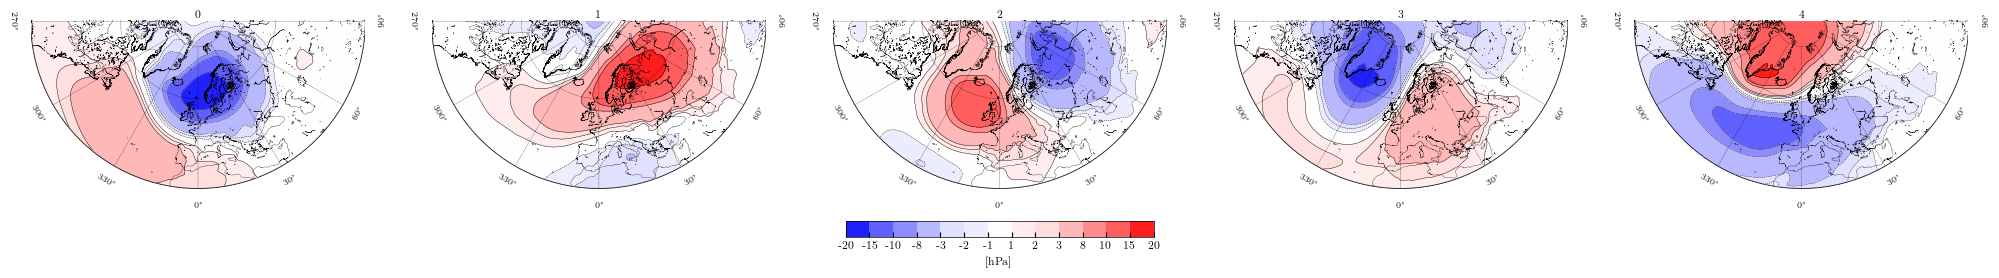

In [8]:
from pattern_reference_manager import PatternReferenceManager


mgr = PatternReferenceManager("/home/a/a271125/work/data/slp.N_djfm_6h_aac_detrend_1deg_north_atlantic.nc",
                              var_name="MSL", 
                              n_pcs=14, 
                              n_clusters=5
                             )

## Nach Sichtung: Mapping anlegen und speichern
#mapping = {0: "SCAN", 1: "ATL-", 2: "NAO+", 3: "NAO-", 4: "DIPOL"}
#mgr.apply_mapping(mapping)
#
## Jetzt mit Namen geplottet!
#mgr.plot_clusters()

In [2]:
## Nach Sichtung: Mapping anlegen und speichern
#mapping = {0: "ATL-", 1: "SCAN", 2: "DIPOL", 3: "NAO+", 4: "NAO-"}
#mgr.apply_mapping(mapping)
#
## Jetzt mit Namen geplottet!
#mgr.plot_clusters()

Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hungarian-Algorithmus gesetzt.


(<Figure size 2500x500 with 6 Axes>,
 [<Axes: title={'center': 'NAO+'}>,
  <Axes: title={'center': 'NAO-'}>,
  <Axes: title={'center': 'ATL-'}>,
  <Axes: title={'center': 'SCAN'}>,
  <Axes: title={'center': 'DIPOL'}>],
 <matplotlib.colorbar.Colorbar at 0x7ffeccec4070>)

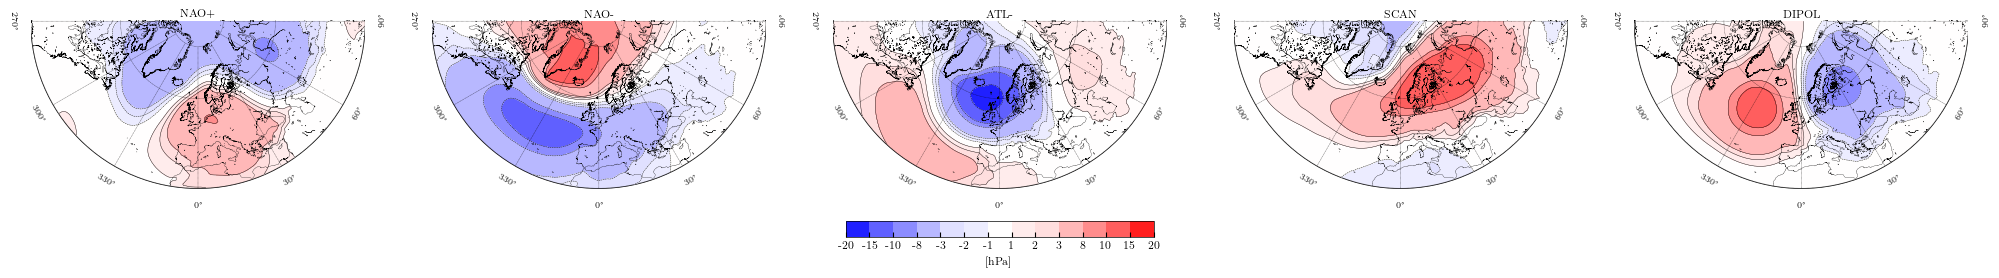

In [24]:
import matplotlib as mpl
from loaders import ClusteringLoader

import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec


mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 8,      # Schriftgröße Achsenbeschriftung
    "axes.titlesize": 8,      # Schriftgröße Titel
    "axes.linewidth": 0.5,     # Achsenlinienbreite
    "lines.linewidth": 0.5,    # Linienbreite
    "font.size": 10,           # Grundschriftgröße
    "legend.fontsize": 8,     # Legende
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    # tick_direction
    "xtick.direction": "in",
    "ytick.direction": "in",
    #"figure.figsize": (5.7, 3.5),  # z.B. 145mm x 90mm in inch
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,
    "pgf.preamble": "\n".join([
        r"\usepackage[T1]{fontenc}",
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[english]{babel}"
    ]),
})


text_width_mm = 145
inches_per_mm = 1/25.4
fig_width_in = text_width_mm * inches_per_mm
fig_height_in = fig_width_in * 0.6

LOG_DIR = '/work/aa0238/a271125/logs/Correct_Normalization'
NETCDF = '/home/a/a271125/work/data/slp.N_djfm_6h_aac_detrend_1deg_north_atlantic.nc'
EXP = 'Experiment_4'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




cloader= ClusteringLoader(
        log_dir      = LOG_DIR,
        experiment   = EXP,
        version      = 68,
        nc_path      = NETCDF,
        device       = device
    )

cloader.plot_composition(cloader.vae_composition)

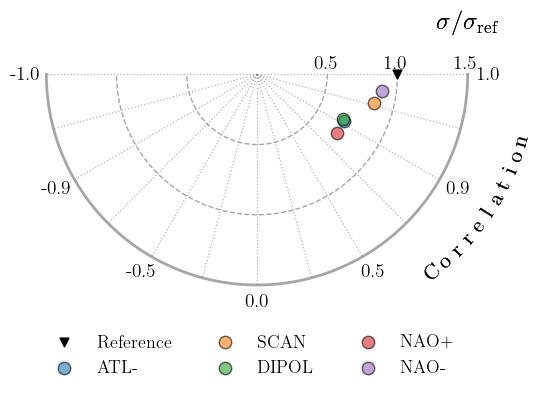

In [7]:
from pattern_taylor import PatternComparator

# Referenzcluster (aus PCA/KMeans) im ReferenceManager
comparator = PatternComparator()
patterns_xr =xr.open_dataarray("all_patterns_neu.nc")
pattern_mean = patterns_xr.mean(dim='version')



figsize = (fig_width_in,fig_width_in*0.8)
fig, ax = plt.subplots(figsize=figsize)

# Wir sammeln die deduplizierten Handles/Labels nur einmal:
unique_h = []
unique_l = []
seen = set()


comparator.plot_taylor_best_match_single(
    model_patterns=[pattern_mean],
    model_labels=[""],
    cluster_labels=list(comparator.manager.get_patterns().cluster.values),
    ax=ax,
    axis_label_kwargs={"fontsize": 18},
    curved_text_kwargs={
        "fontsize": 16,
        "r_max_multiplyer": 1.3,
        "start_angle": -50,
        "end_angle": -15,
    },
    tick_kwargs = {
        "fontsize": 14,
        "corrlabel_r_mult": 1.1,   # Default vorher: 1.2
        "corrlabel_y_mult": -1.08  # Default vorher: -1.14
    },
    marker_kwargs = {
        "marker": "o",
        "s": 80,
        "alpha": 0.6
    }
    )


handles, labels = ax.get_legend_handles_labels()
for h, l in zip(handles, labels):
    if l not in seen:
        unique_h.append(h)
        unique_l.append(l)
        seen.add(l)

# Einzel-Legende entfernen
ax.get_legend().remove()

# Gemeinsame Legende unter den Plots
fig.legend(
    unique_h,
    unique_l,
    loc='lower center',
    bbox_to_anchor=(0.5, 0.15),
    ncol=3,
    frameon=False,
    fontsize=13
)


plt.subplots_adjust(bottom=0.35)  # oder 0.30, je nach Bedarf
plt.savefig(f'./plots/Taylor_mean.pdf', bbox_inches='tight')

plt.show()


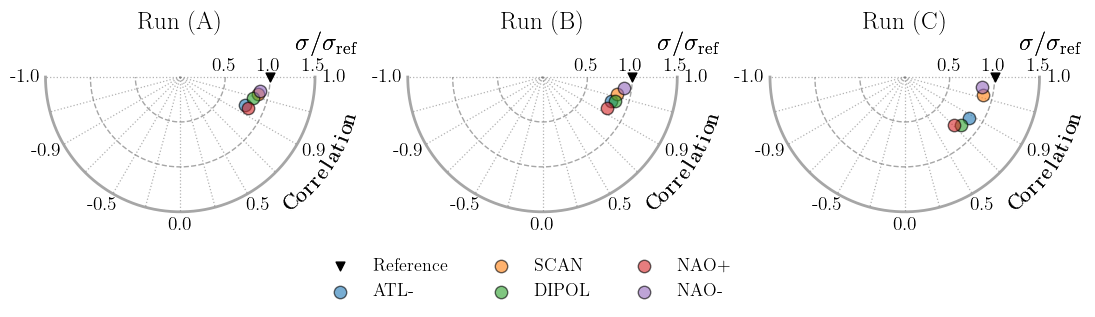

In [9]:
import matplotlib.pyplot as plt

# Annahme: Drei verschiedene Modellpattern
model_patterns = [cloader_a.vae_composition,
                  cloader_b.vae_composition,
                  cloader_c.vae_composition]
model_labels = ["A", "B", "C"]

comparator = PatternComparator()

fig_width_in = 13
fig, axes = plt.subplots(1, 3, figsize=(fig_width_in, fig_width_in * 0.8))

# Wir sammeln die deduplizierten Handles/Labels nur einmal:
unique_h = []
unique_l = []
seen = set()

for i, ax in enumerate(axes):
    comparator.plot_taylor_best_match_single(
        model_patterns=[model_patterns[i]],
        model_labels=[''],
        cluster_labels=list(comparator.manager.get_patterns().cluster.values),
        ax=ax,
        axis_label_kwargs={"fontsize": 18},
        curved_text_kwargs={
            "fontsize": 16,
            "r_max_multiplyer": 1.3,
            "start_angle": -50,
            "end_angle": -15,
        },
        tick_kwargs={
            "fontsize": 14,
            "corrlabel_r_mult": 1.15,
            "corrlabel_y_mult": -1.1
        },
        marker_kwargs={
            "s": 80,
            "alpha": 0.6,
        }
    )
    ax.set_title(f"Run ({model_labels[i]})", fontsize=18, pad=30)

    # Nur einmal – z.B. aus dem ersten Axes – handles/labels holen und deduplizieren
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        for h, l in zip(handles, labels):
            if l not in seen:
                unique_h.append(h)
                unique_l.append(l)
                seen.add(l)

    # Einzel-Legende entfernen
    ax.get_legend().remove()

# Gemeinsame Legende unter den Plots
fig.legend(
    unique_h,
    unique_l,
    loc='lower center',
    bbox_to_anchor=(0.5, 0.30),
    ncol=3,
    frameon=False,
    fontsize=13
)

plt.subplots_adjust(bottom=0.0, top=0.93, wspace=0.28)
plt.savefig('./plots/Taylor_ABC.pdf', bbox_inches='tight')
plt.show()


In [ ]:
import xarray as xr

# ==== Einstellungen ====
N_VERSIONS = 74#101
PATTERN_NETCDF = "all_patterns.nc"     # Pattern-File, nur zum Speichern/Laden von Patterns!
INPUT_NETCDF = NETCDF
VARNAME = 'MSL'                        # Name der Variable im Pattern-Array
REGIME_ORDER = ['NAO-','NAO+','ATL-','SCAN','DIPOL']

# ==== Hilfsfunktion zum robusten Auslesen gespeicherter Versionen ====
def get_loaded_versions(nc_path, varname=VARNAME):
    try:
        ds = xr.open_dataset(nc_path)
        # Suche die version-Koordinate, egal ob DataArray oder Dataset
        if 'version' in ds.coords:
            versions = ds.coords['version'].values
        elif varname in ds and 'version' in ds[varname].dims:
            versions = ds[varname].coords['version'].values
        else:
            print("Warnung: Keine version-Koordinate oder -Dimension gefunden!")
            versions = []
        ds.close()
        return set(versions)
    except FileNotFoundError:
        return set()
    except Exception as e:
        print(f"Fehler beim Lesen der Versionen: {e}")
        return set()

# ==== Haupt-Workflow ====
all_versions = set(range(1, N_VERSIONS))
loaded_versions = get_loaded_versions(PATTERN_NETCDF, varname=VARNAME)
missing_versions = all_versions - loaded_versions

patterns = []

for v in sorted(missing_versions):
    try:
        cloader = ClusteringLoader(
            log_dir=LOG_DIR,
            experiment=EXP,
            version=v,
            nc_path=INPUT_NETCDF,      # Nur Inputdaten als Input!
            device=device,
            regime_order=REGIME_ORDER,
        )
        vae_comp = cloader.get_named_and_sorted_vae_pattern()
        # Sicherstellen, dass KEINE Zeitdimension existiert!
        if 'time' in vae_comp.dims:
            vae_comp = vae_comp.isel(time=0, drop=True)
        # Version als neue Koordinate:
        vae_comp = vae_comp.expand_dims(version=[v])
        patterns.append(vae_comp)
        del cloader
        print(f"Version {v} geladen, shape: {vae_comp.shape}, dims: {vae_comp.dims}")
    except Exception as e:
        print(f"Fehler beim Laden von Version {v}: {e}")

if patterns:
    # Alle neuen als DataArray mit version-Dimension
    patterns_xr = xr.concat(patterns, dim="version")

    try:
        try:
            ds_existing = xr.open_dataset(PATTERN_NETCDF)
            # Falls Dataset, extrahiere das DataArray
            if isinstance(ds_existing, xr.Dataset):
                ds_existing = ds_existing[VARNAME]
            # Sicherstellen, dass version-Dimension überall existiert!
            if 'version' not in ds_existing.dims:
                raise ValueError("Alte Datei hat keine 'version'-Dimension – bitte Pattern-File neu erstellen!")
            if 'version' not in patterns_xr.dims:
                raise ValueError("Neue Patterns haben keine 'version'-Dimension!")
            # Concat über version-Dim
            ds_combined = xr.concat([ds_existing, patterns_xr], dim="version")
            ds_existing.close()
        except FileNotFoundError:
            ds_combined = patterns_xr  # Beim ersten Mal speichern
        ds_combined.to_netcdf(PATTERN_NETCDF)
        print("Neue Versionen gespeichert.")
    except Exception as e:
        print(f"Fehler beim Speichern der NetCDF: {e}")
else:
    print("Keine neuen Versionen zu speichern.")

# ==== Kontrolle, ob alles gespeichert wurde ====
loaded_versions_final = get_loaded_versions(PATTERN_NETCDF, varname=VARNAME)
print(f"Gesamt gespeicherte Versionen: {sorted(loaded_versions_final)}")
if missing_versions - loaded_versions_final:
    print("Warnung: Einige Versionen konnten nicht gespeichert/geladen werden!")
else:
    print("Alle gewünschten Versionen sind jetzt in der NetCDF-Datei.")



In [21]:
import xarray as xr
from loaders import ClusteringLoader

n_versions = 101
patterns = []
regime_order = ['NAO-', 'NAO+', 'ATL-', 'SCAN', 'DIPOL']

for v in range(1, n_versions):
    cloader = ClusteringLoader(
        log_dir=LOG_DIR,
        experiment=EXP,
        version=v,
        nc_path=NETCDF,
        device=device,
        regime_order=regime_order,
    )
    vae_comp = cloader.get_named_and_sorted_vae_pattern()
    # Add version as coordinate
    vae_comp = vae_comp.expand_dims(version=[v])
    patterns.append(vae_comp)
    del cloader
    print(f"Loaded version {v}")

# Concat all patterns along the version dimension
patterns_xr = xr.concat(patterns, dim="version")
patterns_xr.to_netcdf("all_patterns_neu.nc")


Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hungarian-Algorithmus gesetzt.
Loaded version 1
Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hungarian-Algorithmus gesetzt.
Loaded version 2
Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hungarian-Algorithmus gesetzt.
Loaded version 3
Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hungarian-Algorithmus gesetzt.
Loaded version 4
Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hungarian-Algorithmus gesetzt.
Loaded version 5
Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hung

Loaded version 47
Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hungarian-Algorithmus gesetzt.
Loaded version 48
Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hungarian-Algorithmus gesetzt.
Loaded version 49
Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hungarian-Algorithmus gesetzt.
Loaded version 50
Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hungarian-Algorithmus gesetzt.
Loaded version 51
Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Mapping (global) via Hungarian-Algorithmus gesetzt.
Loaded version 52
Führe automatisches Mapping via flächengewichteter Korrelation nach Initialisierung aus...
Automatisches Ma

In [55]:
patterns_xr
std_per_version = patterns_xr.std(dim=('cluster', 'lat', 'lon'))  # shape: (version,)


maxstd_idx = std_per_version.argmax(dim='version').item()
version_coords = patterns_xr['version'].values
maxstd_version_number = version_coords[maxstd_idx]

print(maxstd_version_number)

68


(<Figure size 2500x500 with 6 Axes>,
 [<Axes: title={'center': 'Std Cluster NAO-'}>,
  <Axes: title={'center': 'Std Cluster NAO+'}>,
  <Axes: title={'center': 'Std Cluster ATL-'}>,
  <Axes: title={'center': 'Std Cluster SCAN'}>,
  <Axes: title={'center': 'Std Cluster DIPOL'}>],
 <matplotlib.colorbar.Colorbar at 0x7ffec846dc00>)

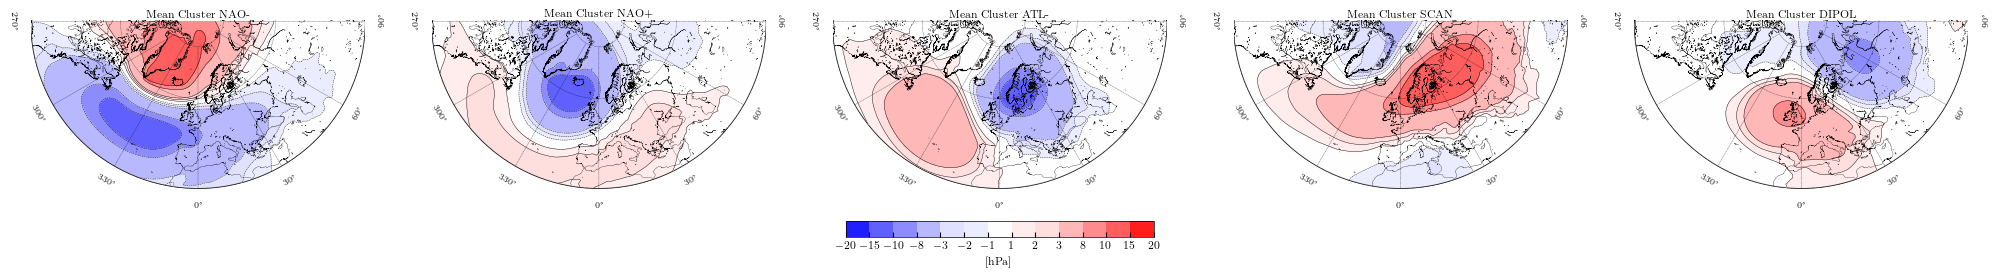

In [ ]:
from plotting import Plotting
import xarray as xr

patterns_xr =xr.open_dataarray("all_patterns_neu.nc")
pattern_mean = patterns_xr.mean(dim='version')
pattern_std  = patterns_xr.std(dim='version')

plotter = Plotting(lon=pattern_mean['lon'].values, lat=pattern_mean['lat'].values)
titles = ["Mean Cluster %s" % i for i in pattern_mean.cluster.values]
plotter.plot_isolines(pattern_mean.values, titles=titles)

titles_std = ["Std Cluster %s" % i for i in pattern_std.cluster.values]
plotter.plot_isolines(pattern_std.values, titles=titles_std)


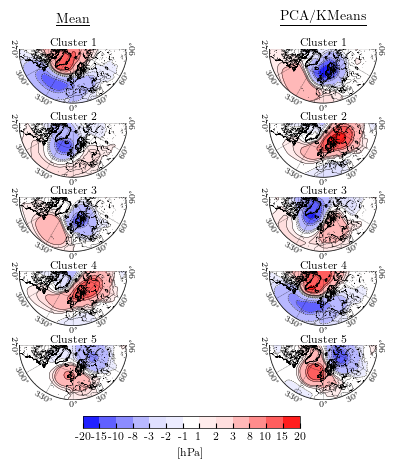

In [91]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def add_column_titles(fig, axs, titles, ypos=0.93, fontsize=10):
    """
    Fügt Spaltentitel zentriert über jeder Spalte hinzu.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
        Die Figure, zu der die Titel hinzugefügt werden sollen.
    axs : numpy.ndarray
        2D Array der Achsen-Objekte, [Zeile, Spalte].
    titles : list of str
        Liste der Spaltentitel.
    ypos : float, optional
        Y-Position im Figure-Koordinatensystem (0=unten, 1=oben).
    fontsize : int, optional
        Schriftgröße der Titel.
    """
    ncols = axs.shape[1]
    assert len(titles) == ncols, "Number of titles must match number of columns"
    for j, title in enumerate(titles):
        ax = axs[0, j]
        pos = ax.get_position()
        xpos = pos.x0 + 0.5 * (pos.x1 - pos.x0)
        fig.text(xpos, ypos, title, ha='center', va='bottom', fontsize=fontsize)
add_column_titles(fig, axs, column_titles, ypos=0.93, fontsize=10)

        
def create_subplot_grid(fig, nrows, ncols, gridspec_kw=None):
    import matplotlib.gridspec as gridspec
    if gridspec_kw is None:
        gridspec_kw = {'wspace': 0.3, 'hspace': 0.3}
    gs = gridspec.GridSpec(nrows, ncols, **gridspec_kw)
    axs = np.array([[fig.add_subplot(gs[i, j]) for j in range(ncols)] for i in range(nrows)])
    return axs



nrows = 5
ncols = 2
fig = plt.figure(figsize=(fig_width_in, fig_width_in * 0.8))
axs = create_subplot_grid(fig, nrows, ncols, gridspec_kw={'wspace': 0.3, 'hspace': 0.35})

sigma = float(pattern_std.values.std())
levels = np.array([-7*sigma, -5*sigma, -2*sigma, 0, 2*sigma, 5*sigma, 7*sigma])

# Deine Werte
std_min = 0
std_white = 2 * sigma
std_max = pattern_std.values.max()

# Farbverlauf: Weiß bleibt bis 2*sigma, dann Rot
cmap_std = LinearSegmentedColormap.from_list(
    'whitetored',
    [
        (0.0, 'white'),
        (std_white/std_max, 'white'),  #
        (1.0, 'red')
    ]
)

plotter = Plotting(lon=pattern_mean['lon'].values, lat=pattern_mean['lat'].values)
plotter_std = Plotting(
                lon = pattern_mean['lon'].values, lat=pattern_mean['lat'].values,
                levels=levels, max_scale=levels[-1],
                base_colors=[(0.0, "white"), (1.0, "red")],
                )

cf_handles_0 = plotter.plot_isolines(pattern_mean, fig=fig, axes=axs[:, 0], show_colorbar=False)[2]
cf_handles_1 = plotter.plot_isolines(cloader.kmeans_composition, fig=fig, axes=axs[:, 1], show_colorbar=False)[2]


column_titles = [r"$\underline{\mathrm{Mean}}$", r"$\underline{\mathrm{PCA/KMeans}}$"]
add_column_titles(fig, axs, column_titles, ypos=0.93, fontsize=10)

orig_left = 0.12
orig_width = 0.76
shrink_factor = 0.5
new_width = orig_width * shrink_factor
new_left = orig_left + 0.5 * (orig_width - new_width)
cbar_ax = fig.add_axes([new_left, 0.05, new_width, 0.025])


# Colorbar hinzufügen, horizontal
cb = fig.colorbar(cf_handles_0[0], cax=cbar_ax, orientation='horizontal', label='[hPa]')
cb.set_ticks(cloader.plotter.levels)  # Optional: eigene Levels
cb.set_ticklabels([str(lvl) for lvl in cloader.plotter.levels])
#fig.tight_layout()
plt.savefig(f'./plots/composition.pdf', bbox_inches='tight')
plt.show()

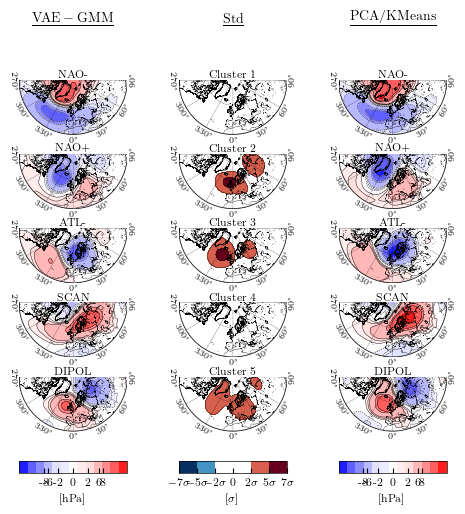

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# --- Subplots erzeugen ---
fig = plt.figure(figsize=(fig_width_in, fig_width_in*0.8))
nrows = 5
ncols = 3
gs = plt.GridSpec(nrows, ncols, wspace=0.3, hspace=0.35)
axs = np.array([[fig.add_subplot(gs[i, j]) for j in range(ncols)] for i in range(nrows)])

# --- Levels definieren (für alle Spalten identisch) ---
sigma = float(pattern_std.values.std())
levels = np.array([-7*sigma, -5*sigma, -2*sigma, 0, 2*sigma, 5*sigma, 7*sigma])

# --- Left: VAE/Mean ---
cf_handles_0 = cloader.plot_composition(cloader.vae_composition, fig=fig, axes=axs[:, 0], show_colorbar=False)[2]

# --- Right: KMeans ---
cf_handles_2 = cloader.plot_composition(cloader.kmeans_composition, fig=fig, axes=axs[:, 2], show_colorbar=False)[2]

# --- Middle: STD mit weißem Bereich ---
threshold = 2*sigma
cmap = plt.get_cmap('RdBu_r', len(levels)-1)
colors = cmap(np.linspace(0, 1, len(levels)-1))
zero_bin = np.where((levels >= -threshold) & (levels <= threshold))[0]
for idx in zero_bin[:-1]:
    colors[idx] = np.array([1,1,1,1])
custom_cmap = ListedColormap(colors)

plotter_std = Plotting(
    lon=pattern_mean['lon'].values, lat=pattern_mean['lat'].values,
    levels=levels, max_scale=levels[-1]
)
plotter_std.cmap = custom_cmap
cf_handles_1 = plotter_std.plot_isolines(pattern_std, fig=fig, axes=axs[:, 1], show_colorbar=False)[2]

# --- Spaltentitel ---
column_titles = [r"$\underline{\mathrm{VAE-GMM}}$", r"$\underline{\mathrm{Std}}$", r"$\underline{\mathrm{PCA/KMeans}}$"]
for j, title in enumerate(column_titles):
    ax = axs[0, j]
    pos = ax.get_position()
    xpos = pos.x0 + 0.5 * (pos.x1 - pos.x0)
    fig.text(xpos, 1, title, ha='center', va='bottom', fontsize=10)

# --- Colorbars unter jeder Spalte ---
cbar_height = 0.025
cbar_y = 0.02

labels_levels = [r"$-7\sigma$", r"$-5\sigma$", r"$-2\sigma$", r"$0$", r"$2\sigma$", r"$5\sigma$", r"$7\sigma$"]

# Links
left_pos = axs[-1, 0].get_position()
cbar_ax_left = fig.add_axes([left_pos.x0, cbar_y, left_pos.x1-left_pos.x0, cbar_height])
cb0 = fig.colorbar(cf_handles_0[0], cax=cbar_ax_left, orientation='horizontal', label='[hPa]')
cb0.set_ticks(levels)
cb0.set_ticklabels([f"{l:.0f}" for l in levels])
cb0.ax.tick_params(labelsize=8)

# Mitte (wie schon bei dir - σ-Labels usw.)
mid_pos = axs[-1, 1].get_position()
cbar_ax_mid = fig.add_axes([mid_pos.x0, cbar_y, mid_pos.x1-mid_pos.x0, cbar_height])
cb1 = fig.colorbar(cf_handles_1[0], cax=cbar_ax_mid, orientation='horizontal', label=r'[$\sigma$]')
cb1.set_ticks(levels)
cb1.set_ticklabels(labels_levels)
cb1.ax.tick_params(labelsize=8)

# Rechts
right_pos = axs[-1, 2].get_position()
cbar_ax_right = fig.add_axes([right_pos.x0, cbar_y, right_pos.x1-right_pos.x0, cbar_height])
cb2 = fig.colorbar(cf_handles_2[0], cax=cbar_ax_right, orientation='horizontal', label='[hPa]')
cb2.set_ticks(levels)
cb2.set_ticklabels([f"{l:.0f}" for l in levels])
cb2.ax.tick_params(labelsize=8)


In [52]:
std_min = np.nanmin(pattern_std.values)
std_max = np.nanmax(pattern_std.values)
print(std_min, std_max)

0.027068 7.1846533


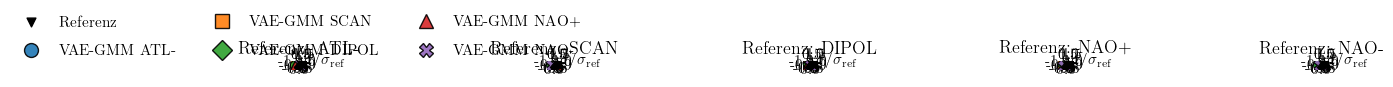

In [3]:
#from pattern_taylor import PatternComparator
#
## Referenzcluster (aus PCA/KMeans) im ReferenceManager
#comparator = PatternComparator()
#
## Muster aus VAE-GMM (z.B. vae_gmm_patterns) als xr.DataArray ("cluster", "lat", "lon")
#comparator.plot_taylor_per_reference(a
#    model_patterns=[cloader.vae_composition],
#    model_labels=["VAE-GMM"],  # Beliebig, kann auch ["KMeans", "VAE-GMM"] etc. sein
#    cluster_labels=list(comparator.manager.get_patterns().cluster.values)  # oder Mapping-Namen
#)
#plt.show()
#

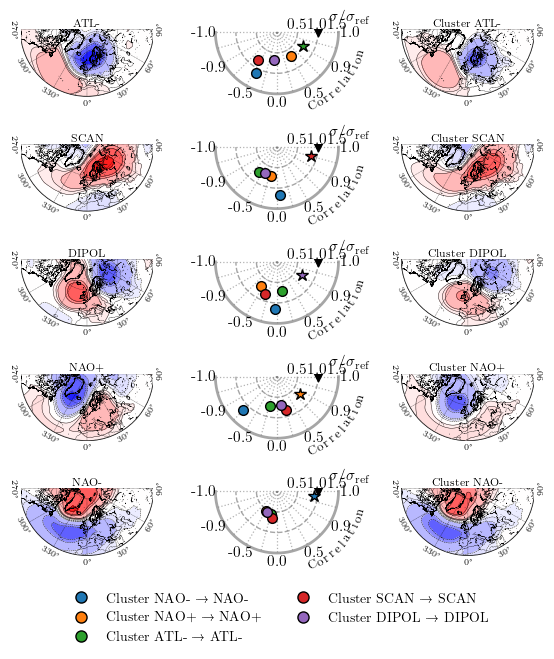

In [30]:
from pattern_taylor import PatternComparator


patterns_model = pattern_mean#cloader.vae_composition
# Übergib den fertig gemappten Referenz-Manager
comp = PatternComparator()#mgr)

# Matching & Plots: (automatische Zuordnung nach Ähnlichkeit)
comp.compare_and_plot(patterns_model, figsize = (fig_width_in,fig_width_in))
plt.savefig(f'./plots/taylor_pred.pdf', bbox_inches='tight')


<Axes: >

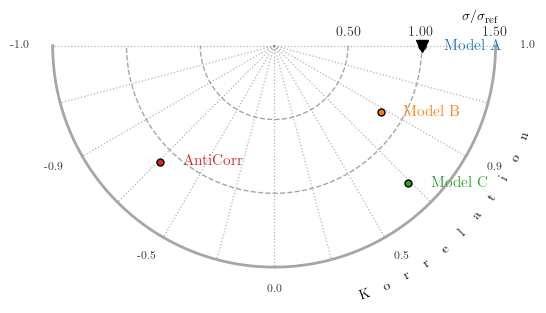

In [29]:
def curved_text(ax, text, radius, center=(0,0), start_angle=-160, end_angle=160, **kwargs):
    # Text wird als Einzelbuchstaben platziert
    n = len(text)
    angles = np.linspace(np.deg2rad(start_angle), np.deg2rad(end_angle), n)
    for i, (char, angle) in enumerate(zip(text, angles)):
        # Position auf dem Kreisrand
        x = center[0] + radius * np.cos(angle)
        y = center[1] + radius * np.sin(angle)
        rotation = np.rad2deg(angle) + 90  # +90, damit es entlang des Kreises steht
        ax.text(x, y, char, rotation=rotation, ha='center', va='center', **kwargs)

def plot_taylor_halfcircle(std_ref, stds, corrs, labels=None, ax=None, r_max=1.5, optimum_idx=None, cluster_colors=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(6,3.7))
        ax.set_aspect('equal', 'box')
        ax.set_xlim(-r_max*1.05, r_max*1.05)
        ax.set_ylim(-r_max*1.05, 0.05*r_max)

        # Standardabweichungskreise (explizit Halbkreise, Rand bei r_max!)
        sigma_ticks = np.arange(0.5, r_max+0.01, 0.5)
        theta = np.linspace(0, np.pi, 300)
        for s in sigma_ticks:
            x = s * np.cos(theta)
            y = -s * np.sin(theta)  # Nach unten!
            lw = 2 if np.isclose(s, r_max) else 1
            ax.plot(x, y, color='grey', lw=lw, ls='-' if np.isclose(s, r_max) else '--', zorder=1, alpha=0.7)
            # Ticks am rechten Rand
            ax.text(s, 0.05, f"{s:.2f}", ha='center', va='bottom', fontsize=10, color='black', alpha=0.8)

        # Korrelationslinien (gleichmäßige Winkel, z.B. alle 15°)
        for deg in np.arange(0, 181, 15):
            angle = np.deg2rad(deg)
            r = np.cos(angle)
            x = [0, r_max * np.cos(angle)]
            y = [0, -r_max * np.sin(angle)]  # Nach unten!
            ax.plot(x, y, color='grey', lw=0.9, ls=':', zorder=1, alpha=0.6)
            # Korrelationslabel an äußeren Rand
            if deg % 30 == 0:
                label_corr = np.cos(angle)
                lx = 1.15 * r_max * np.cos(angle)
                ly = -1.1 * r_max * np.sin(angle)
                ax.text(lx, ly, f"{label_corr:.1f}", fontsize=8, ha='center', va='center', color='k', alpha=0.8)

        # Punkte plotten (immer gleiche Farben)
        if labels is None:
            labels = [f"Mod {i+1}" for i in range(len(stds))]
        for i, (std, corr) in enumerate(zip(stds, corrs)):
            theta = np.arccos(corr)
            r = std / std_ref
            x = r * np.cos(theta)
            y = -r * np.sin(theta)
            marker = 'o'
            ms = 5
            if optimum_idx is not None and i == optimum_idx:
                marker = '*'
                ms = 8
            color = cluster_colors[i] if cluster_colors is not None else f"C{i}"
            ax.plot(x, y, marker, ms=ms, color=color, markeredgecolor='k', label=labels[i], zorder=3)
            ax.text(x+0.1*r_max, y, labels[i], va='center', ha='left', fontsize=11, color=color, zorder=4)

        # Referenzpunkt (σ=1, θ=0 → (1,0))
        ax.plot([1], [0], 'kv', ms=8, label='Referenz', zorder=5)
        #ax.text(1.03, 0.03*r_max, 'Ref', va='bottom', ha='left', fontsize=11, color='k')

        ax.axis('off')
        # Achsen-Labels (unten)

        curved_text(
            ax,
            "Korrelation",
            radius=r_max*1.2,  # etwas größer als die Plots, damit es außen steht
            center=(0,0),
            start_angle=-70,
            end_angle=-20,
            fontsize=10,
            color='k'
        )

        ax.text(r_max * 0.85, 0.13* r_max, r"$\sigma/\sigma_{\rm ref}$", ha='left', va='center', fontsize=10)

        return ax
    

# ---- Beispielaufruf ----
std_ref = 1.0
stds  = [1.0, 0.85, 1.3, 1.1]
corrs = [1.0, 0.85, 0.7, -0.7]
labels = ['Model A', 'Model B', 'Model C', 'AntiCorr']

# Hier Stern beim Optimum (höchste Korrelation)
plot_taylor_halfcircle(std_ref, stds, corrs, labels)


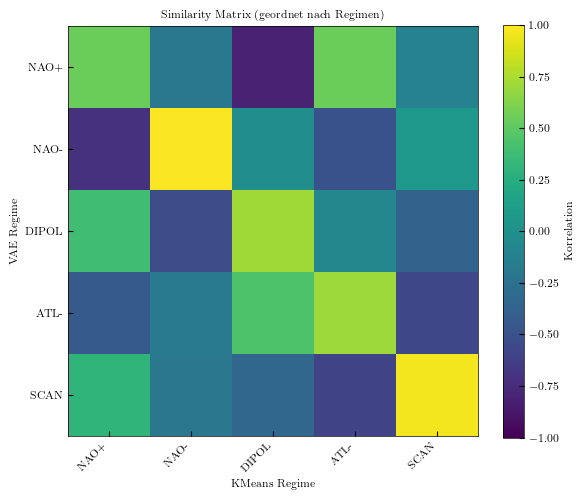

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Einheitliche Regime-Order festlegen:
regime_order = cloader.regime_order or list(cloader.km_to_regime.values())

# 2. Index-Umsetzung von Regime-Name zu Cluster-Index für beide Mappings
vae_name_to_idx = {v: k for k, v in cloader.model_to_regime.items()}
km_name_to_idx = {v: k for k, v in cloader.km_to_regime.items()}

# 3. Similarity-Matrix in Regime-Order sortieren
R = cloader.similarity_matrix
order_vae = [vae_name_to_idx[r] for r in regime_order]
order_km  = [km_name_to_idx[r] for r in regime_order]
R_sorted = R[np.ix_(order_vae, order_km)]

# 4. Plotten mit gleichen Achsen
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(R_sorted, cmap='viridis', vmin=-1, vmax=1)

plt.colorbar(im, ax=ax, label='Korrelation')

ax.set_xticks(range(len(regime_order)))
ax.set_yticks(range(len(regime_order)))
ax.set_xticklabels(regime_order, rotation=45, ha='right')
ax.set_yticklabels(regime_order)

ax.set_xlabel("KMeans Regime")
ax.set_ylabel("VAE Regime")
plt.title("Similarity Matrix (geordnet nach Regimen)")
plt.tight_layout()
plt.show()


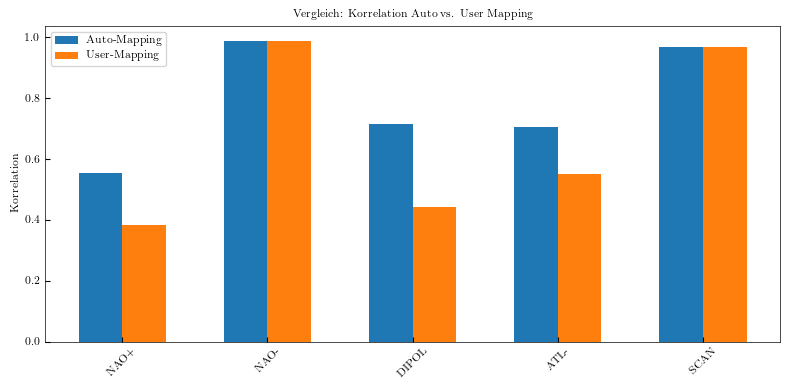

In [5]:
regime_names = cloader.regime_order or list(cloader.km_to_regime.values())
auto_corrs = []
user_corrs = []

R = cloader.similarity_matrix
vae_name_to_idx_auto = {v: k for k, v in cloader.model_to_regime.items()}
vae_name_to_idx_user = {v: k for k, v in cloader.user_mapping.items()} if cloader.user_mapping is not None else {}

for regime in regime_names:
    kmeans_idx = [k for k, v in cloader.km_to_regime.items() if v == regime][0]
    auto_idx = vae_name_to_idx_auto.get(regime, None)
    user_idx = vae_name_to_idx_user.get(regime, None)
    auto_corrs.append(R[auto_idx, kmeans_idx] if auto_idx is not None else np.nan)
    user_corrs.append(R[user_idx, kmeans_idx] if user_idx is not None else np.nan)

x = np.arange(len(regime_names))
plt.figure(figsize=(8,4))
plt.bar(x - 0.15, auto_corrs, width=0.3, label="Auto-Mapping")
plt.bar(x + 0.15, user_corrs, width=0.3, label="User-Mapping")
plt.xticks(x, regime_names, rotation=45)
plt.ylabel("Korrelation")
plt.title("Vergleich: Korrelation Auto vs. User Mapping")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#cloader_v2.regime_order = ["NAO+", "NAO-", "ATL-", "DIPOL", "SCAN"]

fig, axs = plt.subplots(nrows=n_cluster, ncols=3, figsize=(fig_width_in, fig_width_in))
new_titles = ["NAO+", "NAO-", "DIPOL", "EU", "SCAN"]
# Plotte alle drei Varianten (achte auf die richtige Übergabe!)
cf_handles_0 = cloader_v1.plot_composition(cloader_v1.vae_composition, fig=fig, axes=axs[:, 0], show_colorbar=False)[2]
cf_handles_1 = cloader_v2.plot_composition(cloader_v2.vae_composition, fig=fig, axes=axs[:, 1], show_colorbar=False, titles = new_titles)[2]
cf_handles_2 = cloader_v1.plot_composition(cloader_v1.kmeans_composition, fig=fig, axes=axs[:, 2], show_colorbar=False)[2]


fig.subplots_adjust(
    left=0.13,   
    right=0.87,  
    top=0.94,     
    bottom=0.1,  
    wspace=0.25, 
    hspace=0.0,  
)

ax = axs[3, 1]  # Python zählt ab 0!
#ax.set_frame_on(True)
# Standard-Rechteck, das genau die Achse umrahmt:


overshoot_top    = 0.25  # nach oben weiter raus
overshoot_bottom = 0.175  # nach unten etwas raus
overshoot_side   = 0.115  # an den Seiten etwas raus

rect = patches.Rectangle(
    (-overshoot_side, -overshoot_bottom),
    1 + 2*overshoot_side,
    1 + overshoot_top + overshoot_bottom,
    linewidth=2, edgecolor='darkorange', facecolor='none',
    transform=ax.transAxes,
    clip_on=False,
    zorder=30,
    alpha = 0.5
)
ax.add_patch(rect)


#column_titles = ["VAE v1", "VAE v2", "KMeans"]
column_titles = [r"$\underline{\mathrm{VAE-GMM\ A}}$", r"$\underline{\mathrm{VAE-GMM\ B}}$", r"$\underline{\mathrm{PCA/KMeans}}$"]
# Dann wie gehabt in der Schleife

ncols = 3
left = 0.13
right = 0.87
spaltenbreite = (right - left) / ncols

offset = 0.02  # <--- spiele mit diesem Wert!
for j, title in enumerate(column_titles):
    # Offset für die äußeren Spalten
    if j == 0:
        xpos = left + 0.5 * spaltenbreite - offset
    elif j == ncols - 1:
        xpos = left + (j + 0.5) * spaltenbreite + offset
    else:
        xpos = left + (j + 0.5) * spaltenbreite
    fig.text(xpos, 0.955, title, ha='center', va='bottom', fontsize=10)


orig_left = 0.12
orig_width = 0.76
shrink_factor = 0.8
new_width = orig_width * shrink_factor
new_left = orig_left + 0.5 * (orig_width - new_width)
cbar_ax = fig.add_axes([new_left, 0.07, new_width, 0.025])


# Colorbar hinzufügen, horizontal
cb = fig.colorbar(cf_handles_0[0], cax=cbar_ax, orientation='horizontal', label='[hPa]')
cb.set_ticks(cloader_v1.plotter.levels)  # Optional: eigene Levels
cb.set_ticklabels([str(lvl) for lvl in cloader_v1.plotter.levels])
#fig.tight_layout()
plt.savefig(f'./plots/compositions.pdf', bbox_inches='tight')
plt.show()

In [ ]:
for version in range(1,6):
    cloader = ClusteringLoader(
        log_dir      = '/work/aa0238/a271125/logs/Correct_Normalization',
        experiment   = 'Experiment_3',
        version      = version,
        nc_path      = NETCDF,
        device       = device
    )
        
    cloader.plot_composition(cloader.vae_composition)
    plt.show()
    print(str(version)+' done')

In [7]:
import xarray as xr
from tqdm import tqdm

def extract_epoch(filename):
    match = re.search(r'epoch=(\d+)', filename)
    return int(match.group(1)) if match else None

def find_epoch(filenames, n=1, specific_epoch=None):
    # Extrahiere alle gültigen Epochen mit den zugehörigen Dateinamen
    epochs = [(extract_epoch(f), f) for f in filenames if extract_epoch(f) is not None]
    
    # Falls keine validen Einträge gefunden wurden
    if not epochs:
        return None

    # Sortiere nach Epoche absteigend
    epochs.sort(reverse=True, key=lambda x: x[0])

    if specific_epoch is not None:
        # Suche nach einer spezifischen Epoche
        for epoch, filename in epochs:
            if epoch == specific_epoch:
                return filename
        return None  # Falls die spezifische Epoche nicht existiert

    # Falls n größer als die Anzahl der Elemente ist, nehme das letzte Element
    n = min(n, len(epochs))

    return epochs[n-1][1]  # n-1 wegen Nullindexierung


def get_cluster_labels(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    timestamps = []
    latent_features = []
    log_vars = []
    gamma_list = []

    with torch.no_grad():  # No need to track gradients
        for batch in tqdm(dataloader):
            x, time = batch
            x = x.to(model.device)
            
            # Get the latent representation
            x_recon, mu, log_var, z = model(x)
            latent_features.append(mu.detach().cpu())
            log_vars.append(log_var.detach().cpu())
            # Compute the cluster probabilities
            _, gamma = model.gaussian_mixture_log_prob(mu)
            
            # Get the cluster with highest probability
            labels = torch.argmax(gamma, dim=1)
            all_labels.append(labels.cpu())
            gamma_list.append(gamma.cpu())

            timestamps.extend(time)

    return torch.cat(all_labels).numpy(), timestamps, torch.cat(latent_features, dim=0).numpy(), torch.cat(log_vars, dim=0), torch.cat(gamma_list, dim=0)



checkpoint_file = find_epoch(log_files)
#print("Beste Checkpoint-Datei:", checkpoint_file)

checkpoint = torch.load(path+'last.ckpt', map_location="cpu")
current_epoch = checkpoint['epoch']

print(f'load model from epoch {current_epoch}')
model = VAE.load_from_checkpoint(checkpoint_path=checkpoint_file, map_location="cpu")
model.eval()
num_clusters = model.model_config.num_clusters
print('model loaded')


# Laden Sie das originale Xarray-Dataset
original_dataset = xr.open_dataset(file_path)

# Erstellen Sie den CustomDataset und DataLoader
dataset = CustomDataset(nc_file_path=file_path)#
dataloader = DataLoader(dataset, batch_size=400, shuffle=False, num_workers=8)


cluster_labels, timestamps, latent_features, log_var, gamma = get_cluster_labels(model, dataloader)

/tmp/ipykernel_247459/2221005083.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path+'last.ckpt', map_location="cpu")


load model from epoch 399
model loaded


100%|██████████| 54/54 [00:11<00:00,  4.65it/s]


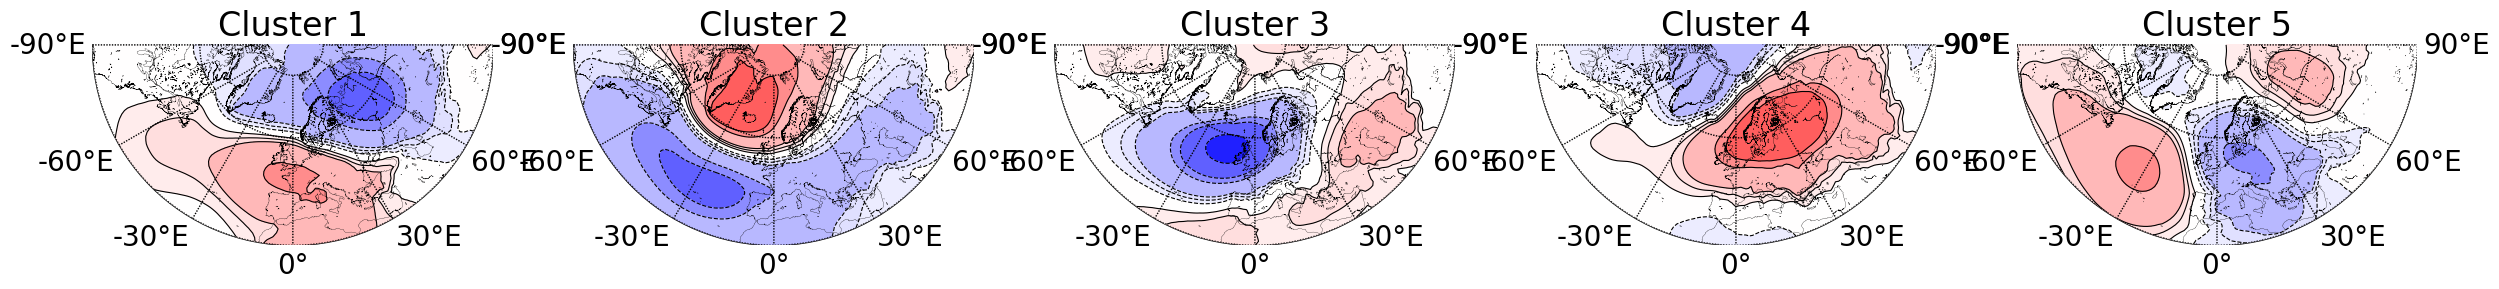

In [9]:
nc_data = xr.open_dataset(file_path)

plotty = Plotting(lon = nc_data.lon, lat = nc_data.lat, fig_scale_factor= 6)#, max_scale =3, levels = np.array([-5,-3,-1,-0.5,0,0.5,1,3,5]))

#load kmeans init:
cluster_labels_init = np.load(f"{version_path}/cluster_labels.npy")  # z. B. shape (N,)
slp_data_init = nc_data['MSL'].assign_coords(cluster=("time", cluster_labels_init)).copy()

# Gruppiere das Dataset nach der neuen "cluster"-Koordinate und berechne den Durchschnitt über "time":
clustered_mean_init = slp_data_init.groupby("cluster").mean(dim="time")

# Optional: Sortiere das Ergebnis nach dem Cluster-Wert:
sorted_clustered_mean_init = clustered_mean_init.sortby("cluster")

fig1, ax1 = plotty.plot_isolines(sorted_clustered_mean_init)

save_path = f'/work/aa0238/a271125/logs/VAE-GMM/Evaluation/{current_experiment}/{version}/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
plt.savefig(f'{save_path}{num_clusters}_kmeans_init_{version}_epoch{current_epoch}.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

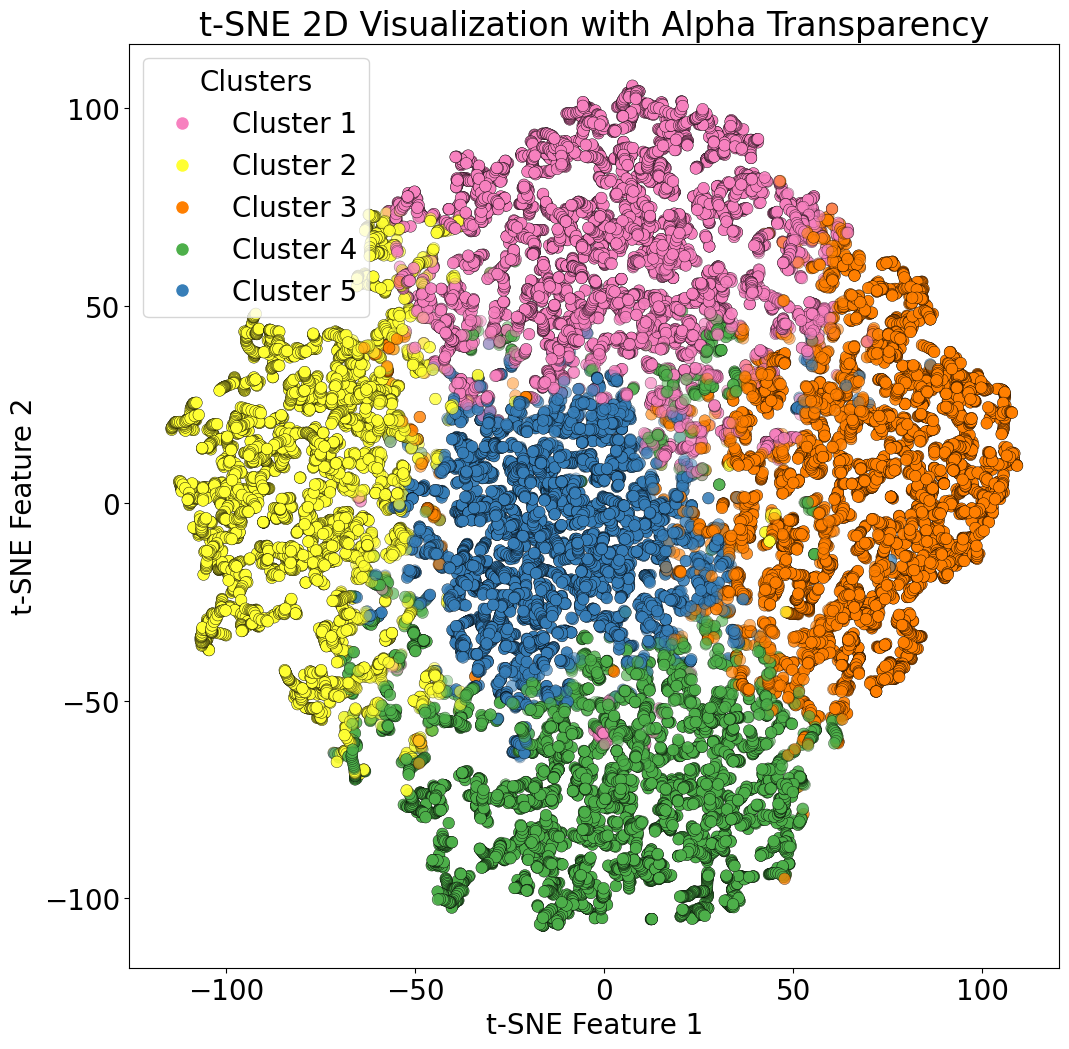

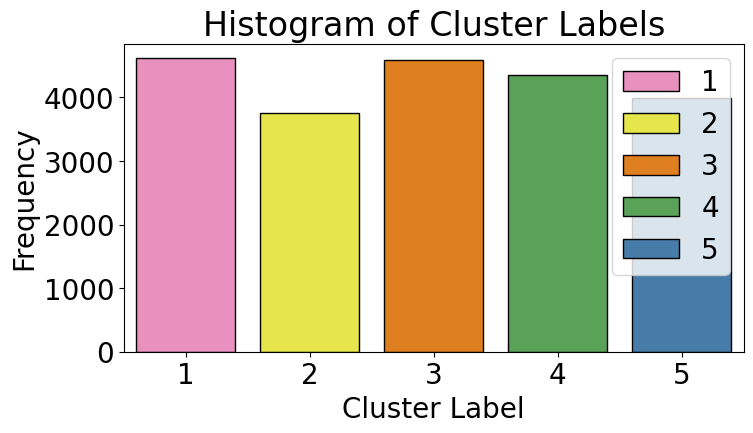

In [14]:
def visualize_tsne_matplotlib(latent_features, cluster_probabilities, perplexity=30, random_state=42, figsize=(12,12)):
    """
    Visualisiert t-SNE mit Matplotlib und verwendet alpha-Transparenz basierend auf max(cluster_probabilities).
    
    Parameter:
    - latent_features: np.array, die latenten Features (n_samples, feature_dim)
    - cluster_probabilities: np.array mit Cluster-Zugehörigkeitswahrscheinlichkeiten (n_samples, n_clusters)
    - n_components: 2 oder 3, Dimensionen für t-SNE
    - perplexity: Perplexity für t-SNE
    - random_state: Zufallsseed für Reproduzierbarkeit
    - figsize: Größe des Plots
    
    Rückgabe:
    - Matplotlib-Figur
    """
    assert cluster_probabilities.shape[0] == latent_features.shape[0], "Anzahl der Punkte und Wahrscheinlichkeiten müssen übereinstimmen!"

    # Berechne t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    tsne_results = tsne.fit_transform(latent_features)

    # Cluster-Zugehörigkeiten und Alpha-Werte berechnen
    cluster_assignments = np.argmax(cluster_probabilities, axis=1)  # Cluster-Labels
    alpha_values = np.max(cluster_probabilities, axis=1)  # Höchste Wahrscheinlichkeit pro Punkt

    # Farben für Cluster setzen
    num_clusters = cluster_probabilities.shape[1]
    palette = sns.color_palette("Set1_r", num_clusters)
    colors = np.array([palette[i] for i in cluster_assignments])  # Farben den Clustern zuordnen

    # 2D- oder 3D-Plot erstellen
    fig = plt.figure(figsize=figsize)
    
    ax = fig.add_subplot(111)
    scatter = ax.scatter(
        tsne_results[:, 0],
        tsne_results[:, 1], 
        c=colors, alpha=alpha_values,
        s=70,
        edgecolor = 'k',
        linewidths=0.3)

    ax.set_xlabel("t-SNE Feature 1")
    ax.set_ylabel("t-SNE Feature 2")
    ax.set_title("t-SNE 2D Visualization with Alpha Transparency")
        
    
    # Legende erstellen
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=10, label=f'Cluster {i+1}') 
               for i in range(num_clusters)]
    ax.legend(handles=handles, loc="best", title="Clusters")
    
   
    
    return fig, ax

    
plt.savefig(f'{save_path}{num_clusters}_cluster_composition_version{version}_epoch{current_epoch}.png', dpi=300, bbox_inches='tight')
cluster_counts = np.bincount(cluster_labels)
cluster_labels_ = np.unique(cluster_labels)

color = sns.color_palette("Set1_r", num_clusters)

cluster_probabilities = gamma.cpu().numpy()

fig, ax = visualize_tsne_matplotlib(latent_features, cluster_probabilities)

save_path = f'/work/aa0238/a271125/logs/MULTI_VaDE_logs/Evaluation/{current_experiment}/{version}/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
        
plt.savefig(f'{save_path}{num_clusters}_cluster_tsne_version{version}_epoch{current_epoch}.png')

fig.show()

plt.figure(figsize=(8, 4))
sns.barplot(x=cluster_labels_+1, y=cluster_counts, hue = cluster_labels_+1, palette = color, edgecolor='black')
plt.xlabel('Cluster Label')
plt.ylabel('Frequency')
plt.title('Histogram of Cluster Labels')
plt.show()

In [70]:
zonal_files = glob.glob('/atm_glomod/data/ERA5_1.0/6hr_1979-2023/*')
print(zonal_files)

[]


In [71]:
for i in range(5):
    cluster = sorted_clustered_mean[i].values
    cluster = cluster[np.newaxis, :]  # Falls cluster ein 2D-Array ist, wird es zu (1, lat, lon)
    if i == 4:
        fig, ax = plotter.plot_isolines(cluster, individual_colorbar=True, save_dir=f"./img/cluster_{i}", titles="")
    else:
        fig, ax = plotter.plot_isolines(cluster, individual_colorbar=False, save_dir=f"./img/cluster_{i}", titles="")


Gespeichert: ./img/cluster_0.png
Gespeichert: ./img/cluster_1.png
Gespeichert: ./img/cluster_2.png
Gespeichert: ./img/cluster_3.png
Gespeichert: ./img/cluster_4.png


In [8]:
import json
import pandas as pd
import numpy as np

# Definiere Filterkriterien (Passe diese Werte an deine Bedürfnisse an)
MIN_SILHOUETTE = 0.1           # Mindestwert für den Silhouette Score (höher = besser)
MIN_CALINSKI_HARABASZ = 18.0     # Mindestwert für den Calinski-Harabasz Index
MAX_DAVIES_BOULDIN = 3.0         # Maximalwert für den Davies-Bouldin Index (niedriger = besser)
TARGET_CLUSTER_ENTROPY = 1.6     # Zielwert für die Cluster Entropy (±0.2)
MAX_LOSS_RECON = 0.025#19            # Obergrenze für den Rekonstruktionsloss (je niedriger, desto besser)

def load_results_to_dataframe(json_path):
    """Liest ein JSON-File ein und erstellt daraus einen DataFrame.
    Es werden dabei die 'config'- und 'metrics'-Dictionaries zusammengeführt."""
    with open(json_path, "r") as f:
        results = json.load(f)
    
    data = []
    for run in results:
        row = {}
        # Nehme alle Parameter aus der Konfiguration
        config = run.get("config", {})
        for key, value in config.items():
            row[f"config_{key}"] = value
        # Nehme alle gemessenen Metriken
        metrics = run.get("metrics", {})
        for key, value in metrics.items():
            row[f"metric_{key}"] = value
        # Zusätzliche Meta-Informationen (z. B. Trial-Name, Status, Training Iteration)
        row["trial_name"] = run.get("trial_name", None)
        row["status"] = run.get("status", None)
        row["training_iteration"] = run.get("training_iteration", None)
        data.append(row)
    
    df = pd.DataFrame(data)
    return df

def filter_good_runs(df):
    """Filtert den DataFrame anhand der definierten Kriterien."""
    filtered = df[
        (df["metric_silhouette"] >= MIN_SILHOUETTE) &
        (df["metric_calinski_harabasz"] >= MIN_CALINSKI_HARABASZ) &
        (df["metric_davies_bouldin"] <= MAX_DAVIES_BOULDIN) &
        (df["metric_cluster_entropy"].between(TARGET_CLUSTER_ENTROPY - 0.2, TARGET_CLUSTER_ENTROPY + 0.2)) &
        (df["metric_loss_recon"] <= MAX_LOSS_RECON)
    ]
    return filtered

def main(json_path):
    df = load_results_to_dataframe(json_path)

    
    good_df = filter_good_runs(df)

    
    # Optional: Sortiere die guten Runs, z.B. nach Silhouette Score absteigend
    good_df = good_df.sort_values(by="metric_silhouette", ascending=False)
    return good_df



        
json_path = "/work/aa0238/a271125/logs_ray/full_multi_vade/version_1/best_results/pareto_results.json"  # Passe den Pfad an
df = main(json_path)



df = df.reset_index(drop=True)
df = df.drop(columns=["trial_name", "status", "training_iteration"])

for key in df.keys():
    print(f"{key}: {round(df[key][0],9)},")
df

config_clustering_lr: 5.929e-06,
config_gmm_end_value: 0.005220209,
config_reg_end_value: 0.385072058,
config_cat_end_value: 0.005362321,
config_temp_end_value: 0.00037127,
config_vae_epochs: 35,
config_gmm_epochs: 80,
config_cat_epochs: 250,
config_reg_epochs: 250,
config_temp_epochs: 240,
config_warmup_epochs: 35,
config_kmeans_init_epoch: 10,
config_clustering_warmup: 25,
config_linear_epochs: 60,
config_cosine_eta_min: 1.2e-08,
config_vae_lr_factor: 0.777187766,
config_vae_lr_patience: 30,
metric_loss_recon: 0.022118412,
metric_silhouette: 0.102225944,
metric_calinski_harabasz: 35.952449799,
metric_davies_bouldin: 2.208251238,
metric_cluster_entropy: 1.583442092,


config_clustering_lr  config_gmm_end_value  config_reg_end_value  \
0              0.000006               0.00522              0.385072   

   config_cat_end_value  config_temp_end_value  config_vae_epochs  \
0              0.005362               0.000371                 35   

   config_gmm_epochs  config_cat_epochs  config_reg_epochs  \
0                 80                250                250   

   config_temp_epochs  ...  config_clustering_warmup  config_linear_epochs  \
0                 240  ...                        25                    60   

   config_cosine_eta_min  config_vae_lr_factor  config_vae_lr_patience  \
0           1.155216e-08              0.777188                      30   

   metric_loss_recon  metric_silhouette  metric_calinski_harabasz  \
0           0.022118           0.102226                  35.95245   

   metric_davies_bouldin  metric_cluster_entropy  
0               2.208251                1.583442  

[1 rows x 22 columns]

FileNotFoundError: [Errno 2] No such file or directory: '/work/aa0238/a271125/logs/MULTI_VaDE_logs/single_plots/temporal_persistence/12/.png.png'

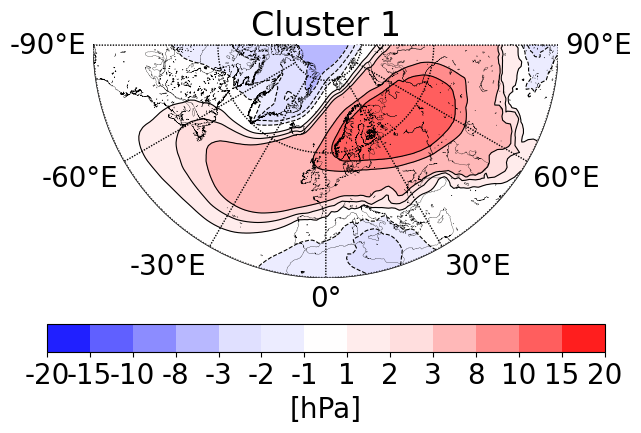

In [9]:

plotter = Plotting(lon = nc_data.lon, lat = nc_data.lat, fig_scale_factor= 6)
fig, plots = plotter.plot_isolines(sorted_clustered_mean, individual_colorbar=True, save_dir=f'/work/aa0238/a271125/logs/MULTI_VaDE_logs/single_plots/{current_experiment}/{version}/',)


In [ ]:
## get first and latest time of nc file

nc_data.lon.min()

In [ ]:
fig_2d = visualize_tsne(latent_features, cluster_labels, timestamps, n_components=2, colors = color)
fig_2d.show()

    
# Speichern als interaktives HTML
#fig_2d.write_html(f'{save_path}{num_clusters}_cluster_tsne_version{version}_epoch{current_epoch}.html')

In [ ]:
def plot_annealing(annealing_epochs, max_kld_weight, ax):
    epochs = np.arange(0, annealing_epochs, 1)
    m = max_kld_weight/np.max(epochs)
    ax.plot(epochs, m*epochs)
    


fig, ax = plt.subplots(1, 1, figsize=(8, 4))

plot_annealing(annealing_epochs=70, max_kld_weight=1.0, ax=ax)
plot_annealing(annealing_epochs=39, max_kld_weight=1.0, ax=ax)
plot_annealing(annealing_epochs=70, max_kld_weight=3.0, ax=ax)
plot_annealing(annealing_epochs=70, max_kld_weight=2.0, ax=ax)



plt.xlabel('Epochs')
plt.ylabel('KLD Weight')
plt.title('Annealing of KLD Weight')
plt.show()

In [ ]:
latent_features.shape

In [ ]:
#clustering using KMeans++
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
z_scaled = scaler.fit_transform(latent_features)


kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42).fit(latent_features)
kmeans_scaled = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42).fit(z_scaled)
# plotting cluster with labels using PCA
color = sns.color_palette("Set1_r", num_clusters)


nc_data = xr.open_dataset(file_path)
slp_data = nc_data['MSL']# Angenommen, SLP-Daten sind vierdimensional [time, level, lat, lon]
slp_data.coords['cluster'] = ('time', kmeans.labels_)
clustered_mean = slp_data.groupby('cluster').mean(dim='time')

sorted_clustered_mean = clustered_mean.sortby('cluster')


plotter = Plotting(lon = nc_data.lon, lat = nc_data.lat, fig_scale_factor= 6)
plotter.plot_isolines(sorted_clustered_mean)

# Calculate the frequency of each cluster
cluster_counts = np.bincount(kmeans.labels_)
cluster_labels_ = np.unique(sorted_clustered_mean['cluster'].values)

color = sns.color_palette("Set1_r", num_clusters)



plt.figure(figsize=(8, 4))
sns.barplot(x=cluster_labels_+1, y=cluster_counts, palette = color, edgecolor='black')
plt.xlabel('Cluster Label')
plt.ylabel('Frequency')
plt.title('Histogram of Cluster Labels')
plt.show()


centers = kmeans.cluster_centers_
tsne = TSNE(n_components=2,  perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(latent_features)
cluster_labels = kmeans.predict(latent_features)
tsne_centers = np.array([
                tsne_results[cluster_labels == i].mean(axis=0)
                for i in range(len(kmeans.cluster_centers_))
                ])
# Plotten der Datenpunkte
plt.figure(figsize=(10, 8))
for cluster_id in np.unique(cluster_labels):
    # Datenpunkte des Clusters
    cluster_points = tsne_results[cluster_labels == cluster_id]
    plt.scatter(
        cluster_points[:, 0], cluster_points[:, 1],
        alpha=0.4,  # Transparenz der Punkte
        label=f'Cluster {cluster_id}'
    )

# Plotten der Clusterzentren
plt.scatter(
    tsne_centers[:, 0], tsne_centers[:, 1],
    c='black', label='Cluster Centers', s=200, marker='X'
)

# Plot-Anpassungen
plt.title('t-SNE Visualization with Cluster Centers')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:


# Berechne die Standardabweichung (sqrt(exp(log_var)))
std_dev = torch.exp(0.5 * log_var)

# Mittelwert und Standardabweichung für jede Dimension
mean_std_per_dim = std_dev.mean(dim=0).detach().cpu().numpy()
std_std_per_dim = std_dev.std(dim=0).detach().cpu().numpy()

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(mean_std_per_dim)), mean_std_per_dim, yerr=std_std_per_dim, fmt='o', capsize=5)
plt.title("Verteilung der Standardabweichungen pro Latent-Dimension")
plt.xlabel("Latent-Dimension")
plt.ylabel("Standardabweichung")
plt.grid(True)
plt.show()

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(latent_features)

In [ ]:
# gaussian clustering

gmm = GaussianMixture(n_components=num_clusters, covariance_type='full', n_init=20, random_state=42).fit(latent_features)

# plotting cluster with labels using tsne
color = sns.color_palette("Set1_r", num_clusters)

plt.figure(figsize=(10, 8))
for cluster_id in np.unique(gmm.predict(latent_features)):
    # Datenpunkte des Clusters
    cluster_points = tsne_results[gmm.predict(latent_features) == cluster_id]
    plt.scatter(
        cluster_points[:, 0], cluster_points[:, 1],
        alpha=0.4,  # Transparenz der Punkte
        label=f'Cluster {cluster_id}',
        s=10,
    )


nc_data = xr.open_dataset(file_path)
slp_data = nc_data['MSL']# Angenommen, SLP-Daten sind vierdimensional [time, level, lat, lon]
slp_data.coords['cluster'] = ('time', gmm.predict(latent_features))
clustered_mean = slp_data.groupby('cluster').mean(dim='time')

sorted_clustered_mean = clustered_mean.sortby('cluster')


plotter = Plotting(lon = nc_data.lon, lat = nc_data.lat, fig_scale_factor= 6)
plotter.plot_isolines(sorted_clustered_mean)

100%|██████████| 54/54 [00:02<00:00, 23.15it/s]


(<Figure size 3000x600 with 5 Axes>,
 array([<Axes: title={'center': 'Cluster 1'}>,
        <Axes: title={'center': 'Cluster 2'}>,
        <Axes: title={'center': 'Cluster 3'}>,
        <Axes: title={'center': 'Cluster 4'}>,
        <Axes: title={'center': 'Cluster 5'}>], dtype=object))

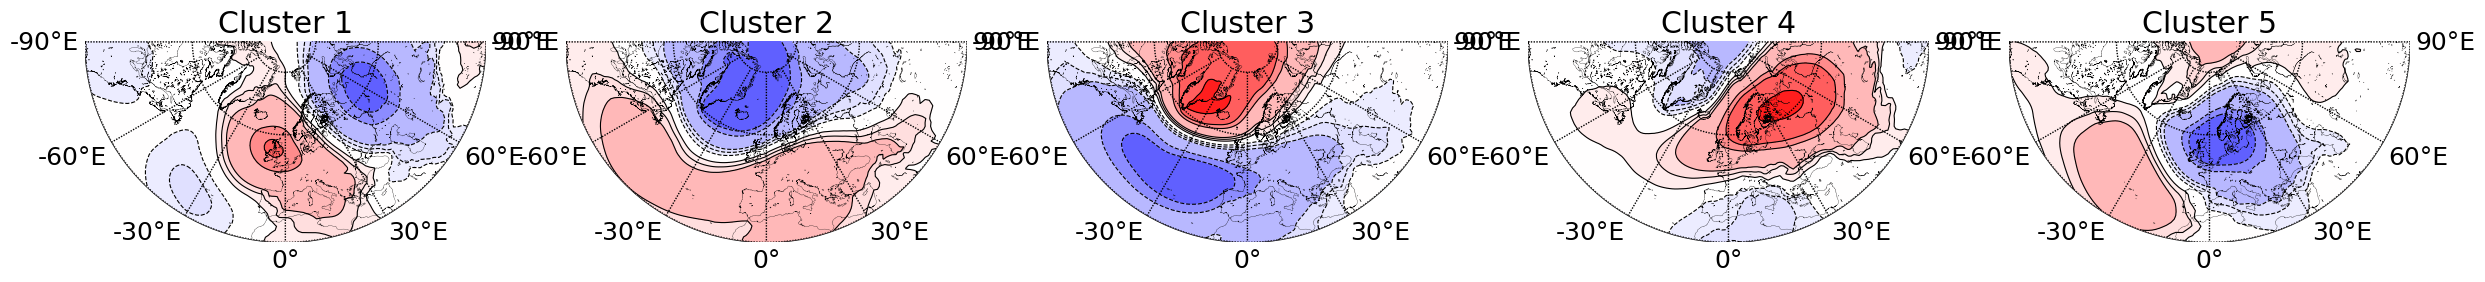

In [11]:
from sklearn.decomposition import PCA

nc_data = xr.open_dataset(file_path)
plotter = Plotting(
    lon = nc_data.lon,
    lat = nc_data.lat,
    fig_scale_factor= 6,
    max_scale = 20,
    levels = np.array([-20, -15, -10, -8, -3, -2, -1, 1, 2, 3, 8, 10, 15, 20]),
    fontsize = 18
)


dataset_kmeans = CustomDataset(nc_file_path=file_path, sqrt = True, drop_pol = False)
dataloader_kmeans = DataLoader(dataset_kmeans, batch_size=400, shuffle=False, num_workers=8)


data_list = []

with torch.no_grad():  # No need to track gradients
        for batch in tqdm(dataloader_kmeans):
            x, time = batch
            data_list.append(x)

# PCA of data_list

data = torch.cat(data_list, dim=0).cpu().numpy()

data_reshaped = data[:, 0, :, :].reshape(data.shape[0], -1)  # (time, lon*lat)

pca = PCA(n_components=20)
pca_results = pca.fit_transform(data_reshaped)

# kmeans on pca_results 5 Clusters

kmeans_pca = KMeans(n_clusters=5, n_init = 100).fit(pca_results)

# plotting cluster with labels using PCA
color = sns.color_palette("Set1_r", 5)

slp_data = nc_data['MSL']
slp_data.coords['cluster'] = ('time', kmeans_pca.labels_)
clustered_mean = slp_data.groupby('cluster').mean(dim='time')

sorted_clustered_mean = clustered_mean.sortby('cluster')


plotter.plot_isolines(sorted_clustered_mean)


In [12]:
for i in range(5):
    cluster = sorted_clustered_mean[i].values
    cluster = cluster[np.newaxis, :]  # Falls cluster ein 2D-Array ist, wird es zu (1, lat, lon)
    if i == 0:
        fig, ax = plotter.plot_isolines(cluster, individual_colorbar=True, save_dir=f"./img/cluster_{i}", titles="")
    else:
        fig, ax = plotter.plot_isolines(cluster, individual_colorbar=False, save_dir=f"./img/cluster_{i}", titles="")


Gespeichert: ./img/cluster_0.png
Gespeichert: ./img/cluster_1.png
Gespeichert: ./img/cluster_2.png
Gespeichert: ./img/cluster_3.png
Gespeichert: ./img/cluster_4.png


In [ ]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def load_tensorboard_scalars(logdir, scalar_name):
    """
    Lädt TensorBoard-Skalare aus einer gegebenen Logdatei.

    :param logdir: Pfad zu den TensorBoard-Logs.
    :param scalar_name: Name des Skalaren, der extrahiert werden soll (z. B. 'loss' oder 'accuracy').
    :return: Liste mit (Step, Value)-Tupeln.
    """
    event_acc = EventAccumulator(logdir, size_guidance={'scalars': 0})
    event_acc.Reload()

    if scalar_name not in event_acc.Tags()['scalars']:
        print(f"Warnung: '{scalar_name}' nicht in {logdir} gefunden.")
        return []

    events = event_acc.Scalars(scalar_name)
    return [(e.step, e.value) for e in events]

def plot_tensorboard_scalars(base_dir, experiments_with_versions, scalar_name, title="TensorBoard Comparison"):
    """
    Plottet TensorBoard-Skalardaten für verschiedene Experimente und Versionen.

    :param base_dir: Basisverzeichnis der TensorBoard-Logs.
    :param experiments_with_versions: Dictionary {experiment: [version1, version2, ...]}.
    :param scalar_name: Name des Skalaren, der geplottet werden soll.
    :param title: Titel des Plots.
    """
    plt.figure(figsize=(10, 6))

    for experiment, versions in experiments_with_versions.items():
        for version in versions:
            log_path = os.path.join(base_dir, experiment, version)
            if not os.path.exists(log_path):
                print(f"Pfad nicht gefunden: {log_path}")
                continue
            
            data = load_tensorboard_scalars(log_path, scalar_name)
            if data:
                steps, values = zip(*data)
                plt.plot(steps, values, label=f"{experiment} - {version}")

    plt.xlabel("Training Steps")
    plt.ylabel(scalar_name)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
from sklearn.decomposition import PCA

nc_data = xr.open_dataset(file_path)
plotter = Plotting(
    lon = nc_data.lon,
    lat = nc_data.lat,
    fig_scale_factor= 6,
    max_scale = 15,
    levels = np.array([-15, -10, -8, -3, -2, -1, 1, 2, 3, 8, 10, 15]),
)


dataset_kmeans = CustomDataset(nc_file_path=file_path, sqrt = True, drop_pol = False)
dataloader_kmeans = DataLoader(dataset_kmeans, batch_size=400, shuffle=False, num_workers=8)


data_list = []

with torch.no_grad():  # No need to track gradients
        for batch in tqdm(dataloader_kmeans):
            x, time = batch
            data_list.append(x)

# PCA of data_list

data = torch.cat(data_list, dim=0).cpu().numpy()

data_reshaped = data[:, 0, :, :].reshape(data.shape[0], -1)  # (time, lon*lat)

pca = PCA(n_components=20)
pca_results = pca.fit_transform(data_reshaped)

# kmeans on pca_results 5 Clusters

kmeans_pca = KMeans(n_clusters=5, n_init = 100).fit(pca_results)

# plotting cluster with labels using PCA
color = sns.color_palette("Set1_r", 5)

slp_data = nc_data['MSL']
slp_data.coords['cluster'] = ('time', kmeans_pca.labels_)
clustered_mean = slp_data.groupby('cluster').mean(dim='time')

sorted_clustered_mean = clustered_mean.sortby('cluster')


plotter.plot_isolines(sorted_clustered_mean)


In [ ]:
# Listen zur Speicherung der Cluster-Zuordnung
time_list = []
cluster_list = []

with torch.no_grad():  # Kein Gradient-Tracking notwendig
    for batch in tqdm(dataloader):
        x, time = batch
        x = x.to(model.device)

        # Erhalte den latenten Code aus dem VAE
        x_recon, mu, log_var, z = model(x)
        _, gamma = model.gaussian_mixture_log_prob(mu)
            
        # Wähle das Cluster mit der höchsten Wahrscheinlichkeit
        labels = torch.argmax(gamma, dim=1).cpu().numpy()
        time = np.array(time)

        # Speichere Werte
        time_list.extend(time)
        cluster_list.extend(labels)

# Falls noch nicht geschehen: Konvertiere die Zeitstempel
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sortiere nach Zeit
df = df.sort_values(by=["cluster_label", "timestamp"])

# Erkenne, wann ein Cluster neu startet (wenn der vorherige Zeitpunkt zu weit entfernt ist)
df["prev_time"] = df.groupby("cluster_label")["timestamp"].shift(1)

# Definiere ein Trennkriterium: Wenn zwischen zwei Zeitpunkten mehr als 5 Tage liegen, ist es ein neues Ereignis
time_threshold = pd.Timedelta(days=5)
df["new_event"] = (df["timestamp"] - df["prev_time"]) > time_threshold

# Weise eine Event-ID zu jedem Cluster-Zeitraum zu (jedes neue Ereignis bekommt eine eigene ID)
df["event_id"] = df.groupby("cluster_label")["new_event"].cumsum()

# Berechne die Dauer jedes einzelnen Cluster-Ereignisses
cluster_events = df.groupby(["cluster_label", "event_id"])["timestamp"].agg(["min", "max"])
cluster_events["lifetime"] = (cluster_events["max"] - cluster_events["min"]).dt.total_seconds() / 86400  # in Tagen


In [ ]:
import cftime
import matplotlib.pyplot as plt
import seaborn as sns

# KMeans Labels und Zeitstempel in DataFrame speichern
df_kmeans = pd.DataFrame({
    "timestamp": nc_data.time.values,  # Zeitwerte aus NetCDF
    "cluster_label": kmeans_pca.labels_
})

# Konvertiere CFTime in Pandas-kompatibles Datetime64
df_kmeans["timestamp"] = pd.to_datetime(df_kmeans["timestamp"].astype(str))

# Berechne die Lebensdauer für jede Cluster-Periode
df_kmeans = df_kmeans.sort_values(by=["cluster_label", "timestamp"])
df_kmeans["prev_time"] = df_kmeans.groupby("cluster_label")["timestamp"].shift(1)

# Definiere ein Trennkriterium: Wenn zwischen zwei Zeitpunkten mehr als 5 Tage liegen, ist es ein neues Ereignis
time_threshold = pd.Timedelta(days=5)
df_kmeans["new_event"] = (df_kmeans["timestamp"] - df_kmeans["prev_time"]) > time_threshold

# Weise eine Event-ID zu jedem Cluster-Zeitraum zu
df_kmeans["event_id"] = df_kmeans.groupby("cluster_label")["new_event"].cumsum()

# Berechnung der Cluster Persistence für PCA + KMeans
cluster_persistence_kmeans = df_kmeans.groupby(["cluster_label", "event_id"])["timestamp"].agg(["min", "max"])
cluster_persistence_kmeans["lifetime"] = (cluster_persistence_kmeans["max"] - cluster_persistence_kmeans["min"]).dt.total_seconds() / 86400  # in Tagen


# ML-Modell (VAE-GMM)
df_ml = cluster_events.reset_index()[["lifetime"]].copy()
df_ml["Method"] = "VAE-GMM"

# PCA + KMeans
df_kmeans_viz = cluster_persistence_kmeans.reset_index()[["lifetime"]].copy()
df_kmeans_viz["Method"] = "PCA-KMeans"

# Beide DataFrames zusammenfügen
df_combined = pd.concat([df_ml, df_kmeans_viz])


plt.figure(figsize=(8, 6))
sns.violinplot(x="Method", y="lifetime", data=df_combined, hue = "Method", legend = True, palette="muted", cut=0)

plt.xlabel("Clustering Methode")
plt.ylabel("Cluster Persistence (Lebensdauer in Tagen)")
plt.title("Vergleich: VAE-GMM vs. PCA-KMeans")
plt.show()


In [ ]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sn

mse_list_ml = []

with torch.no_grad():  # Kein Gradient-Tracking nötig
    for batch in dataloader:
        x, _ = batch  # Ignoriere den Zeitstempel
        x = x.to(model.device)

        # Rekonstruktion aus dem Modell
        x_recon, _, _, _ = model(x)

        # MSE berechnen (über alle Feature-Dimensionen mitteln)
        mse = torch.mean((x - x_recon) ** 2, dim=(1, 2, 3))  # Annahme: (Batch, C, H, W)
        mse_list_ml.extend(mse.cpu().numpy())

# MSE in DataFrame speichern
df_mse_ml = pd.DataFrame({"MSE": mse_list_ml, "Method": "VAE-GMM"})



# PCA-Inverse Transformation (Rekonstruktion)
pca_reconstructed = pca.inverse_transform(kmeans_pca.cluster_centers_[kmeans_pca.labels_])

# MSE zwischen Originaldaten und PCA-Rekonstruktion berechnen
mse_list_kmeans = [mean_squared_error(orig, recon) for orig, recon in zip(data_reshaped, pca_reconstructed)]

# MSE in DataFrame speichern
df_mse_kmeans = pd.DataFrame({"MSE": mse_list_kmeans, "Method": "PCA-KMeans"})

df_mse_combined = pd.concat([df_mse_ml, df_mse_kmeans])

# Mittelwert und Standardabweichung pro Methode berechnen
df_mse_summary = df_mse_combined.groupby("Method")["MSE"].agg(["mean", "std"]).reset_index()

# Umbenennen für bessere Lesbarkeit
df_mse_summary.rename(columns={"mean": "MSE_mean", "std": "MSE_std"}, inplace=True)
                      

plt.figure(figsize=(8, 6))

# Boxplot für die MSE-Verteilung nach Methode
sns.boxplot(x="Method", y="MSE", data=df_mse_combined, palette="muted", hue = "Method", legend = True)

plt.xlabel("Clustering Methode")
plt.ylabel("MSE (Rekonstruktionsfehler)")
plt.title("Vergleich: MSE-Verteilung für VAE-GMM & PCA-KMeans")

plt.show()


In [11]:
import os
import glob
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator



# ---------------------------
# Loss Monitoring
# ---------------------------

def load_tensorboard_scalars(logdir, scalar_name):
    """
    Lädt TensorBoard-Skalare aus einer gegebenen Logdatei.

    :param logdir: Pfad zu den TensorBoard-Logs.
    :param scalar_name: Name des Skalaren, der extrahiert werden soll (z. B. 'loss' oder 'accuracy').
    :return: Liste mit (Step, Value)-Tupeln.
    """
    event_acc = EventAccumulator(logdir, size_guidance={'scalars': 0})
    event_acc.Reload()

    if scalar_name not in event_acc.Tags()['scalars']:
        print(f"Warnung: '{scalar_name}' nicht in {logdir} gefunden.")
        return []

    events = event_acc.Scalars(scalar_name)
    return [(e.step, e.value) for e in events]

def plot_tensorboard_scalars(base_dir, experiments_with_versions, scalar_name, title="TensorBoard Comparison"):
    """
    Plottet TensorBoard-Skalardaten für verschiedene Experimente und Versionen.

    :param base_dir: Basisverzeichnis der TensorBoard-Logs.
    :param experiments_with_versions: Dictionary {experiment: [version1, version2, ...]}.
    :param scalar_name: Name des Skalaren, der geplottet werden soll.
    :param title: Titel des Plots.
    """
    plt.figure(figsize=(10, 6))

    for experiment, versions in experiments_with_versions.items():
        for version in versions:
            log_path = os.path.join(base_dir, experiment,'version_'+version)
            if not os.path.exists(log_path):
                print(f"Pfad nicht gefunden: {log_path}")
                continue
            
            data = load_tensorboard_scalars(log_path, scalar_name)
            if data:
                steps, values = zip(*data)
                plt.plot(steps, values, label=f"{experiment} - {version}")

    plt.xlabel("Training Steps")
    plt.ylabel(scalar_name)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# ---------------------------
# Laden der Modelle und DataLoader
# ---------------------------

def find_best_checkpoint(log_files):
    """
    Findet den Checkpoint, der "last" im Dateinamen enthält – falls vorhanden.
    Falls nicht, wird der Checkpoint mit der höchsten Zahl (egal ob 'epoch=' oder 'step=') zurückgegeben.
    """
    if not log_files:
        return None
    # Suche nach Dateien, die "last" (unabhängig von Groß-/Kleinschreibung) enthalten
    last_files = [f for f in log_files if "last" in f.lower()]
    if last_files:
        # Falls mehrere, kann man hier noch sortieren, z.B. nach Erstellungsdatum; hier nehmen wir den ersten:
        return last_files[0]
    
    # Falls keine "last"-Datei gefunden wurde, extrahiere die Nummern und wähle die höchste
    def extract_number(filename):
        match = re.search(r'(?:epoch|step)=(\d+)', filename)
        return int(match.group(1)) if match else 0
    return sorted(log_files, key=extract_number)[-1]


def load_models(log_dir, experiments_with_versions, file_path, batch_size=400):
    """
    Lädt mehrere Modellversionen anhand des experiments_with_versions-Dictionaries
    und erstellt einmalig einen DataLoader.
    Rückgabe: (models, dataloader)
      models: Dictionary mit Schlüsseln wie "optimizing_clustering_v42" und den geladenen Modellen.
    """
    
    dataset = CustomDataset(nc_file_path=file_path)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    
    loaded_models = {}
    for experiment, versions in experiments_with_versions.items():
        for version in versions:
            print(f"Lade Modell für {experiment}, Version {version}...")
            path = os.path.join(log_dir, experiment, f"version_{version}", "checkpoints")
            if not os.path.exists(path):
                print(f"Pfad existiert nicht: {path}")
                continue
            log_files = glob.glob(os.path.join(path, '*.ckpt'))
            checkpoint_file = find_best_checkpoint(log_files)
            if not checkpoint_file:
                print(f"Kein gültiger Checkpoint gefunden für {experiment}, Version {version}")
                continue
            print(f"Gefundener Checkpoint: {checkpoint_file}")
            model = VAE.load_from_checkpoint(checkpoint_path=checkpoint_file, map_location="cpu")
            model.eval()
            key = f"{experiment}_v{version}"
            loaded_models[key] = model
    return loaded_models, dataloader

# ---------------------------
# Extraktion der Outputs
# ---------------------------


def extract_outputs_from_models(models, dataloader, apply_pca_kmeans=True, n_clusters=5):
    """
    Extrahiert Daten aus dem DataLoader und berechnet für jedes Modell (im Dictionary 'models')
    die VAE-GMM-Outputs (Rekonstruktionen, Clusterlabels und mu). Zusätzlich wird immer PCA+KMeans
    auf den Rohdaten durchgeführt.
    
    Rückgabe-Dictionary:
      {
         "raw": {"time": np.array([...]), "x": Tensor([...])},
         "models": {
             "optimizing_clustering_v42": {
                 "cluster_labels": np.array([...]),
                 "x_recon": Tensor([...]),
                 "mu": Tensor([...])
             },
             "optimizing_clustering_v44": { ... },
             ...
         },
         "pca_kmeans": {"cluster_labels": np.array([...])}
      }
    """
    outputs = {"raw": {"time": [], "x": []}, "models": {}}
    # Initialisiere für jedes Modell ein Unter-Dictionary
    for model_name in models.keys():
        outputs["models"][model_name] = {"cluster_labels": [], "x_recon": [], "mu": []}
    
    # Alle Berechnungen ohne Gradienten verfolgen
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Verarbeite Batches"):
            x, t = batch
            outputs["raw"]["time"].extend(np.array(t))
            outputs["raw"]["x"].append(x.cpu())
            for model_name, model in models.items():
                # Modell auf das entsprechende Gerät schicken
                x_device = x.to(model.device)
                x_recon, mu, log_var, z = model(x_device)
                _, gamma = model.gaussian_mixture_log_prob(mu)
                labels = torch.argmax(gamma, dim=1).cpu().numpy()
                outputs["models"][model_name]["cluster_labels"].extend(labels)
                outputs["models"][model_name]["x_recon"].append(x_recon.cpu())
                outputs["models"][model_name]["mu"].append(mu.cpu())
    
    # Zusammenführen der Batch-Ergebnisse
    outputs["raw"]["x"] = torch.cat(outputs["raw"]["x"], dim=0)
    outputs["raw"]["time"] = np.array(outputs["raw"]["time"])
    for model_name in models.keys():
        outputs["models"][model_name]["x_recon"] = torch.cat(outputs["models"][model_name]["x_recon"], dim=0)
        outputs["models"][model_name]["cluster_labels"] = np.array(outputs["models"][model_name]["cluster_labels"])
        outputs["models"][model_name]["mu"] = torch.cat(outputs["models"][model_name]["mu"], dim=0)
    
    # PCA + KMeans wird immer durchgeführt
    if apply_pca_kmeans:
        print("Berechne PCA + KMeans auf Rohdaten...")
        # Annahme: Die Eingabedaten haben die Form (N, C, H, W) und wir verwenden den ersten Kanal
        data_reshaped = outputs["raw"]["x"][:, 0, :, :].reshape(outputs["raw"]["x"].shape[0], -1)
        pca = PCA(n_components=20)
        pca_results = pca.fit_transform(data_reshaped)
        kmeans = KMeans(n_clusters=n_clusters, n_init=100)
        kmeans.fit(pca_results)
        outputs["pca_kmeans"] = {"cluster_labels": kmeans.labels_}
    
    return outputs


# ---------------------------
# Metrikfunktionen
# ---------------------------

def compute_mse(outputs, method, model_name=None, n_clusters=5):
    """
    Berechnet den Mean Squared Error (MSE).
    
    Für "VAE-GMM" wird der MSE zwischen den Rohdaten (outputs["raw"]["x"]) und den Rekonstruktionen 
    (outputs["models"][model_name]["x_recon"]) berechnet.
    
    Für "PCA-KMeans" wird die PCA-Inverse-Rekonstruktion aus den Rohdaten erzeugt und mit den Originaldaten verglichen.
    
    :param outputs: Das hierarchische Dictionary der extrahierten Daten.
    :param method: "VAE-GMM" oder "PCA-KMeans"
    :param model_name: Eindeutiger Modellname (wird für VAE‑GMM benötigt).
    :param n_clusters: Anzahl der Cluster für PCA‑KMeans (wird hier nicht explizit genutzt, da outputs bereits PCA-KMeans enthält).
    :return: DataFrame mit den Spalten "MSE", "Model" und "Method".
    """
    if method == "VAE-GMM":
        # Erwartet, dass outputs["models"][model_name]["x_recon"] existiert
        mse_list = torch.mean((outputs["raw"]["x"] - outputs["models"][model_name]["x_recon"]) ** 2, dim=(1, 2, 3)).cpu().numpy()
        df = pd.DataFrame({"MSE": mse_list, "Model": model_name, "Method": method})
        return df
    elif method == "PCA-KMeans":
        # Wir verwenden hier die bereits in outputs["pca_kmeans"] berechneten Clusterlabels,
        # aber zur MSE-Berechnung rekonstruieren wir die Daten erneut:
        data_reshaped = outputs["raw"]["x"][:, 0, :, :].reshape(outputs["raw"]["x"].shape[0], -1)
        pca = PCA(n_components=20)
        pca_results = pca.fit_transform(data_reshaped)
        kmeans = KMeans(n_clusters=n_clusters, n_init=100)
        kmeans.fit(pca_results)
        pca_reconstructed = pca.inverse_transform(kmeans.cluster_centers_[kmeans.labels_])
        mse_list = [mean_squared_error(orig, recon) for orig, recon in zip(data_reshaped, pca_reconstructed)]
        df = pd.DataFrame({"MSE": mse_list, "Model": "PCA-KMeans", "Method": method})
        return df
    else:
        raise ValueError("Ungültige Methode. Bitte 'VAE-GMM' oder 'PCA-KMeans' angeben.")

def compute_cluster_persistence_custom(cluster_labels, timestamps, method_name, time_threshold_hours=10, skip_n=0):
    """
    Berechnet die Lebensdauer der Cluster-Ereignisse (Cluster Persistence) basierend auf 
    aufeinanderfolgenden Zeitstempeln. Ein neues Ereignis wird gestartet, wenn entweder
    der zeitliche Abstand zwischen zwei Einträgen größer als time_threshold_hours ist 
    oder wenn sich das Clusterlabel ändert – wobei bis zu skip_n falsche Labels toleriert werden.
    
    :param cluster_labels: Array der Clusterzuordnungen (Länge N).
    :param timestamps: Array oder Pandas Series mit Zeitstempeln (z. B. datetime), Länge N.
    :param method_name: Name der Clustering-Methode.
    :param time_threshold_hours: Schwellenwert in Stunden, ab dem ein neuer Event angenommen wird.
    :param skip_n: Anzahl tolerierter falscher Clusterlabels innerhalb eines Ereignisses.
    :return: DataFrame mit den Spalten "lifetime" (in Tagen) und "Method".
    """
    import pandas as pd
    
    # Erstelle DataFrame
    df = pd.DataFrame({
        "timestamp": pd.to_datetime(timestamps),
        "cluster_label": cluster_labels
    }).reset_index(drop=True)
    
    result = []
    t_start = df["timestamp"].iloc[0]
    current_label = df["cluster_label"].iloc[0]
    skip_counter = 0
    
    for i in range(1, len(df)):
        t_prev = df["timestamp"].iloc[i-1]
        t_current = df["timestamp"].iloc[i]
        cl_current = df["cluster_label"].iloc[i]
        
        diff_hours = (t_current - t_prev).total_seconds() / 3600
        
        # Prüfe, ob der zeitliche Abstand zu groß ist
        if diff_hours > time_threshold_hours:
            # Ereignis endet beim vorherigen Eintrag
            result.append((t_start, t_prev))
            t_start = t_current
            current_label = cl_current
            skip_counter = 0
        else:
            # Prüfe, ob sich das Label ändert
            if cl_current == current_label:
                skip_counter = 0  # Zurücksetzen, wenn das Label wieder passt
            else:
                skip_counter += 1
                if skip_counter > skip_n:
                    # Mehr als erlaubte Anzahl Abweichungen → Ereignis beenden
                    result.append((t_start, t_prev))
                    t_start = t_current
                    current_label = cl_current
                    skip_counter = 0

    # Letztes Ereignis hinzufügen
    result.append((t_start, df["timestamp"].iloc[-1]))
    
    # Erstelle DataFrame aus den Ereignissen und berechne die Lebensdauer in Tagen
    events = pd.DataFrame(result, columns=["start", "end"])
    events["lifetime"] = (events["end"] - events["start"]).dt.total_seconds() / 86400
    # Begrenze maximale Persistenz auf 20 Tage
    events.loc[events["lifetime"] > 20, "lifetime"] = 20
    events["Method"] = method_name
    return events[["lifetime", "Method"]]






def compute_cluster_composition(nc_data, cluster_labels, var='MSL'):
    """
    Berechnet die mittlere Feldkomposition pro Cluster aus dem Original-nc Dataset.
    
    :param nc_data: xarray.Dataset, z.B. geladen mit xr.open_dataset(file_path)
    :param cluster_labels: Array mit Clusterzuordnungen, Länge muss der Zeit-Dimension entsprechen.
    :param var: Name der Variable, für die der Mittelwert berechnet wird (z.B. "MSL")
    :return: xarray.DataArray mit den gemittelten Werten pro Cluster, sortiert nach Cluster
    """
    # Kopie erstellen, um das Original-Dataset nicht zu verändern
    nc_data = nc_data.copy()
    # Weise die Clusterlabels als neue Koordinate zu (entsprechend der Zeit-Dimension)
    nc_data = nc_data.assign_coords(cluster=("time", cluster_labels))
    # Berechne den Mittelwert pro Cluster
    clustered_mean = nc_data[var].groupby("cluster").mean(dim="time")
    # Sortiere nach dem Clusterindex
    sorted_clustered_mean = clustered_mean.sortby("cluster")
    return sorted_clustered_mean


# ---------------------------
# Plotfunktionen
# ---------------------------

def plot_mse_comparison(df_mse):
    """
    Erstellt einen Boxplot für den MSE-Vergleich.
    Auf der x-Achse werden kurze Labels verwendet:
      - "PCA/K-Means" für PCA-KMeans,
      - "Exp 1", "Exp 2", … für die anderen Modelle.
    Eine Legende zeigt das vollständige Mapping.
    """
    # Erzeuge ein Mapping für die Modelle:
    # Alle Einträge, die nicht "PCA-KMeans" sind, werden in alphabetischer Reihenfolge nummeriert.
    unique_models = [m for m in df_mse["Model"].unique() if m != "PCA-KMeans"]
    unique_models_sorted = sorted(unique_models)
    mapping = {}
    for i, m in enumerate(unique_models_sorted, start=1):
        mapping[m] = f"Exp {i}"
    mapping["PCA-KMeans"] = "PCA/K-Means"
    
    # Neue Spalte mit den kurzen Labels:
    df_mse["Model_short"] = df_mse["Model"].map(mapping)
    
    plt.figure(figsize=(8, 6))
    sns.boxplot(
        x="Model_short", 
        y="MSE", 
        data=df_mse, 
        hue="Model_short", 
        palette="Set1", 
        showmeans=True,
        meanprops={"marker": "v", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": 8}
    )
    plt.xlabel("Modell")
    plt.ylabel("MSE (Rekonstruktionsfehler)")
    plt.title("Vergleich: MSE für VAE-GMM & PCA-KMeans")
    plt.tight_layout()
    
    # Erstelle eine benutzerdefinierte Legende:
    handles = []
    for orig, short in mapping.items():
        handles.append(plt.Line2D([], [], marker="s", linestyle="", label=f"{short}: {orig}", color="black"))
    plt.legend(handles=handles, title="Modelldefinitionen", bbox_to_anchor=(1.05, 1), loc="upper left")
    
    plt.show()


def plot_violin_persistence(df_persistence):
    """
    Erstellt einen Violinplot für die Cluster Persistence.
    Auf der x-Achse werden kurze Labels verwendet:
      - "PCA/K-Means" für PCA-KMeans,
      - "Exp 1", "Exp 2", … für die anderen Modelle.
    Eine Legende zeigt das vollständige Mapping.
    """
    # Erzeuge ein Mapping ähnlich wie oben:
    unique_methods = [m for m in df_persistence["Method"].unique() if m != "PCA-KMeans"]
    unique_methods_sorted = sorted(unique_methods)
    mapping = {}
    for i, m in enumerate(unique_methods_sorted, start=1):
        mapping[m] = f"Exp {i}"
    mapping["PCA-KMeans"] = "PCA/K-Means"
    
    # Neue Spalte mit kurzen Labels:
    df_persistence["Method_short"] = df_persistence["Method"].map(mapping)
    
    plt.figure(figsize=(8, 6))
    sns.violinplot(x="Method_short", y="lifetime", data=df_persistence, palette="muted", hue="Method_short", legend = True, cut=0, inner="quartile")
    plt.xlabel("Clustering Methode")
    plt.ylabel("Cluster Persistence (T)")
    plt.title("Vergleich: Cluster Persistence für VAE-GMM & PCA-KMeans")
    plt.tight_layout()
    
    # Benutzerdefinierte Legende:
    handles = []
    for orig, short in mapping.items():
        handles.append(plt.Line2D([], [], marker="s", linestyle="", label=f"{short}: {orig}", color="black"))
    plt.legend(handles=handles, title="Modelldefinitionen", bbox_to_anchor=(1.05, 1), loc="upper left")
    
    plt.show()

# ---------------------------
# Main-Skript: Integration aller Schritte
# ---------------------------


Lade Modell für Results_Experiment_1, Version 0...
Gefundener Checkpoint: /work/aa0238/a271125/logs/MULTI_VaDE_logs/Results_Experiment_1/version_0/checkpoints/last.ckpt
Lade Modell für Results_Experiment_1, Version 1...
Gefundener Checkpoint: /work/aa0238/a271125/logs/MULTI_VaDE_logs/Results_Experiment_1/version_1/checkpoints/last.ckpt
Lade Modell für Results_Experiment_1, Version 2...
Gefundener Checkpoint: /work/aa0238/a271125/logs/MULTI_VaDE_logs/Results_Experiment_1/version_2/checkpoints/last.ckpt
Lade Modell für Results_Experiment_1, Version 3...
Gefundener Checkpoint: /work/aa0238/a271125/logs/MULTI_VaDE_logs/Results_Experiment_1/version_3/checkpoints/last.ckpt
Lade Modell für Results_Experiment_1, Version 4...
Gefundener Checkpoint: /work/aa0238/a271125/logs/MULTI_VaDE_logs/Results_Experiment_1/version_4/checkpoints/last.ckpt
Lade Modell für Results_Experiment_1, Version 5...
Gefundener Checkpoint: /work/aa0238/a271125/logs/MULTI_VaDE_logs/Results_Experiment_1/version_5/checkpoi

Verarbeite Batches: 100%|██████████| 54/54 [01:04<00:00,  1.20s/it]


Berechne PCA + KMeans auf Rohdaten...


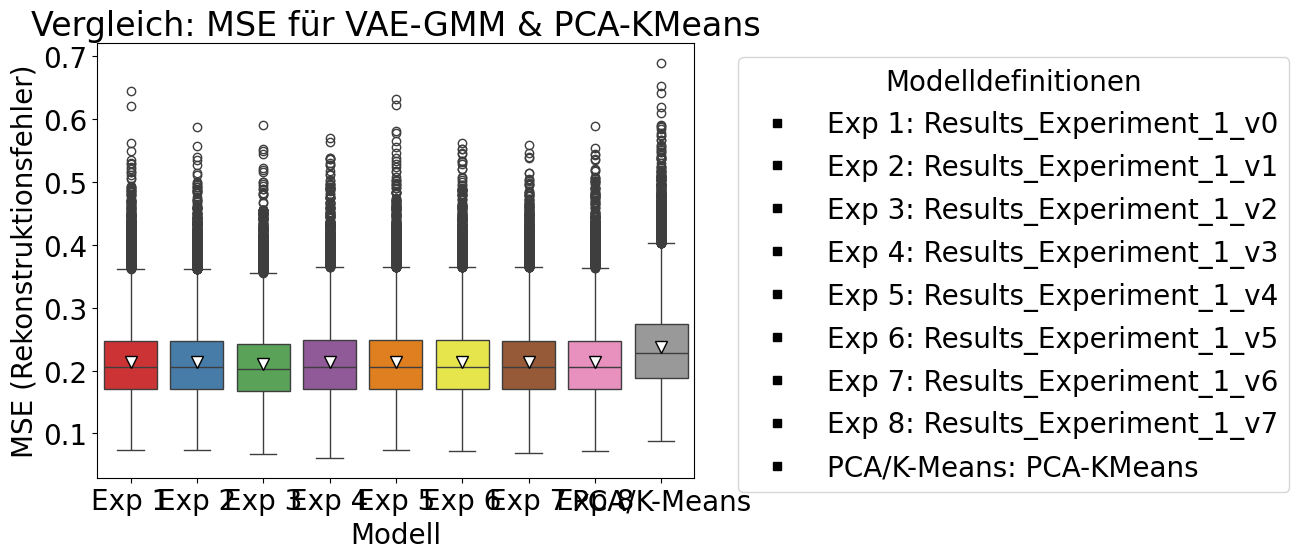

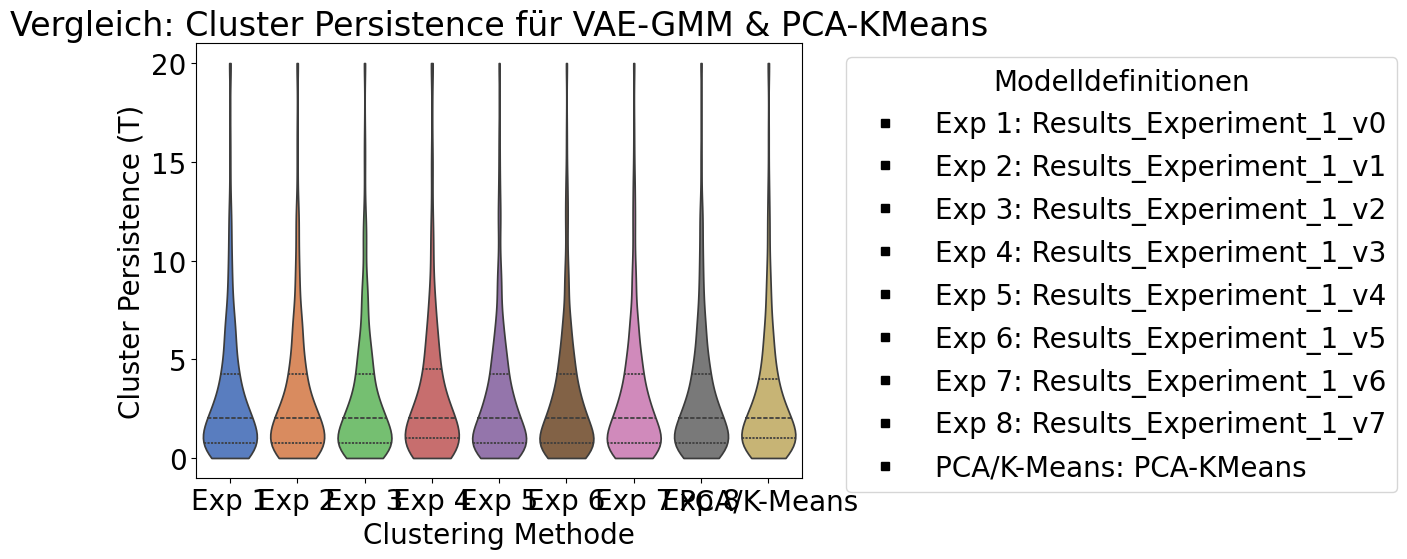

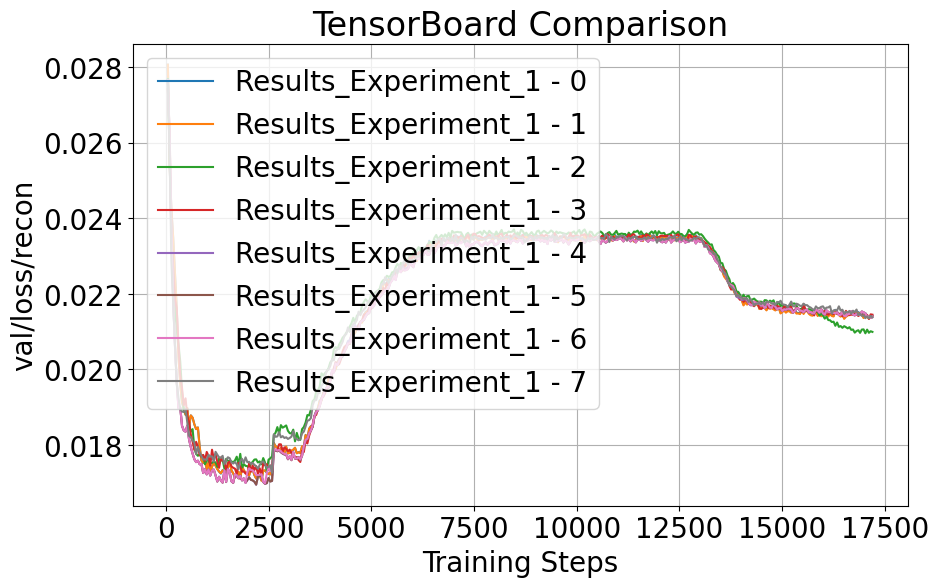

In [12]:
# Parameter und Pfade
log_dir = "/work/aa0238/a271125/logs/MULTI_VaDE_logs/"
file_path = "/home/a/a271125/work/data/slp.N_djfm_6h_aac_detrend_1deg_north_atlantic.nc"
experiments_with_versions = {
    #"kmeans_init_tuned": ["6", "18", "19", "20"],
    "Results_Experiment_1": ["0", "1", "2", "3", "4", "5", "6", "7"],
}

## 1. Modelle laden
models, dataloader = load_models(log_dir, experiments_with_versions, file_path, batch_size=400)
#
## 2. Outputs extrahieren: Hier werden alle Rohdaten, modellabhängige VAE-GMM-Outputs und PCA-KMeans-Labels gesammelt.
outputs = extract_outputs_from_models(models, dataloader, apply_pca_kmeans=True, n_clusters=5)

# 3. MSE-Berechnungen
mse_dfs = []
for model_name in outputs["models"].keys():
    df_mse_model = compute_mse(outputs, method="VAE-GMM", model_name=model_name)
    mse_dfs.append(df_mse_model)
# MSE für PCA-KMeans
df_mse_pca = compute_mse(outputs, method="PCA-KMeans", n_clusters=5)
mse_dfs.append(df_mse_pca)
df_mse_combined = pd.concat(mse_dfs, ignore_index=True)
plot_mse_comparison(df_mse_combined)

# 4. Cluster Persistence-Berechnungen

    # Cluster Persistence für jedes VAE-GMM-Modell
cp_dfs = []
for model_name in outputs["models"].keys():
    cp_df = compute_cluster_persistence_custom(
        outputs["models"][model_name]["cluster_labels"],
        outputs["raw"]["time"],
        method_name=model_name,
        time_threshold_hours=10  # Passe den Schwellenwert an, wenn nötig
    )
    cp_dfs.append(cp_df)

    # Cluster Persistence für PCA-KMeans
cp_df_pca = compute_cluster_persistence_custom(
    outputs["pca_kmeans"]["cluster_labels"],
    outputs["raw"]["time"],
    method_name="PCA-KMeans",
    time_threshold_hours=10
)
cp_dfs.append(cp_df_pca)

df_cp_combined = pd.concat(cp_dfs, ignore_index=True)
plot_violin_persistence(df_cp_combined)
# 5. Cluster Composition-Plots für alle Modelle

nc_data = xr.open_dataset(file_path)

#plotter = Plotting(lon=nc_data.lon, lat=nc_data.lat, fig_scale_factor=6,
#                  levels = np.array([-20, -15, -10, -8, -3, -2, -1, -0.1, 0.1, 1, 2, 3, 8, 10, 15, 20]))
#
# Für jedes Modell aus den Outputs: 
#for model_name in outputs["models"].keys():
#    print(f"Erstelle Cluster Composition Plot für {model_name}...")
#    # Nutze die Clusterlabels, die von diesem Modell kommen
#    comp = compute_cluster_composition(nc_data, outputs["models"][model_name]["cluster_labels"], var='MSL')
#    fig, ax = plotter.plot_isolines(comp)
#    fig.suptitle(f"Cluster Composition für {model_name}")
#
#    plt.show()
#    # Optional: Speichern
#    save_path = f"/work/aa0238/a271125/logs/MULTI_VaDE_logs/Evaluation/composition_{model_name}.png"
#    fig.savefig(save_path, dpi=300, bbox_inches='tight')
#    print(f"Plot für {model_name} gespeichert unter: {save_path}")
#
## Zusätzlich kannst du auch einen Composition-Plot für PCA-KMeans erstellen:
#print("Erstelle Cluster Composition Plot für PCA-KMeans...")
#comp_pca = compute_cluster_composition(nc_data, outputs["pca_kmeans"]["cluster_labels"], var='MSL')
#fig, ax = plotter.plot_isolines(comp_pca)
#fig.suptitle("Cluster Composition für PCA-KMeans")
#
#plt.show()
#save_path = "/work/aa0238/a271125/logs/MULTI_VaDE_logs/Evaluation/composition_PCA-KMeans.png"
#fig.savefig(save_path, dpi=300, bbox_inches='tight')
#print(f"Plot für PCA-KMeans gespeichert unter: {save_path}")


scalar_name = "val/loss/recon"  # Oder "accuracy", etc.

plot_tensorboard_scalars(log_dir, experiments_with_versions, scalar_name)

In [13]:
df = (outputs["models"][model_name]["cluster_labels"], outputs["raw"]["time"])
df = pd.DataFrame({
    "cluster": outputs["models"][model_name]["cluster_labels"],
    "time"   : outputs["raw"]["time"],
})

df["run_id"] = (df["cluster"] != df["cluster"].shift()).cumsum()

# 3) Für jeden run_id+cluster Startzeit, Endzeit und Länge ermitteln
run_stats = (
    df
    .groupby(["run_id", "cluster"])
    .agg(
        start_time=("time", "first"),
        end_time  =("time", "last"),
        length    =("cluster", "size")
    )
    .reset_index()   # <- OHNE drop=True, dann sind run_id und cluster wieder Spalten
)

# 4) Nach Persistenz filtern (z.B. > 20 Zeitpunkte)
min_length = 150
persistent = run_stats[run_stats["length"] > min_length]

print("Alle Runs:")
print(run_stats.head())
print(f"\nRuns mit length > {min_length}:")
print(persistent)

# 5) Wenn Du die Original‑Zeilen dieser persistenten Runs sehen möchtest:
persistent_run_ids = persistent["run_id"].tolist()
df_persist = df[df["run_id"].isin(persistent_run_ids)]

# z.B. pro Run ausgeben
for run_id, group in df_persist.groupby("run_id"):
    c = group["cluster"].iloc[0]
    st = group["time"].iloc[0]
    ed = group["time"].iloc[-1]
    ln = len(group)
    print(f"\n--- Run {run_id} (Cluster {c}), {ln} Schritte von {st} bis {ed}:")
    print(group)

Alle Runs:
   run_id  cluster           start_time             end_time  length
0       1        4  1979-01-01 00:00:00  1979-01-05 06:00:00      18
1       2        3  1979-01-05 12:00:00  1979-01-05 12:00:00       1
2       3        0  1979-01-05 18:00:00  1979-01-08 12:00:00      12
3       4        2  1979-01-08 18:00:00  1979-01-08 18:00:00       1
4       5        4  1979-01-09 00:00:00  1979-01-13 06:00:00      18

Runs mit length > 150:
      run_id  cluster           start_time             end_time  length
1074    1075        1  2010-01-30 00:00:00  2010-03-09 12:00:00     155

--- Run 1075 (Cluster 1), 155 Schritte von 2010-01-30 00:00:00 bis 2010-03-09 12:00:00:
       cluster                 time  run_id
15120        1  2010-01-30 00:00:00    1075
15121        1  2010-01-30 06:00:00    1075
15122        1  2010-01-30 12:00:00    1075
15123        1  2010-01-30 18:00:00    1075
15124        1  2010-01-31 00:00:00    1075
...        ...                  ...     ...
15270     

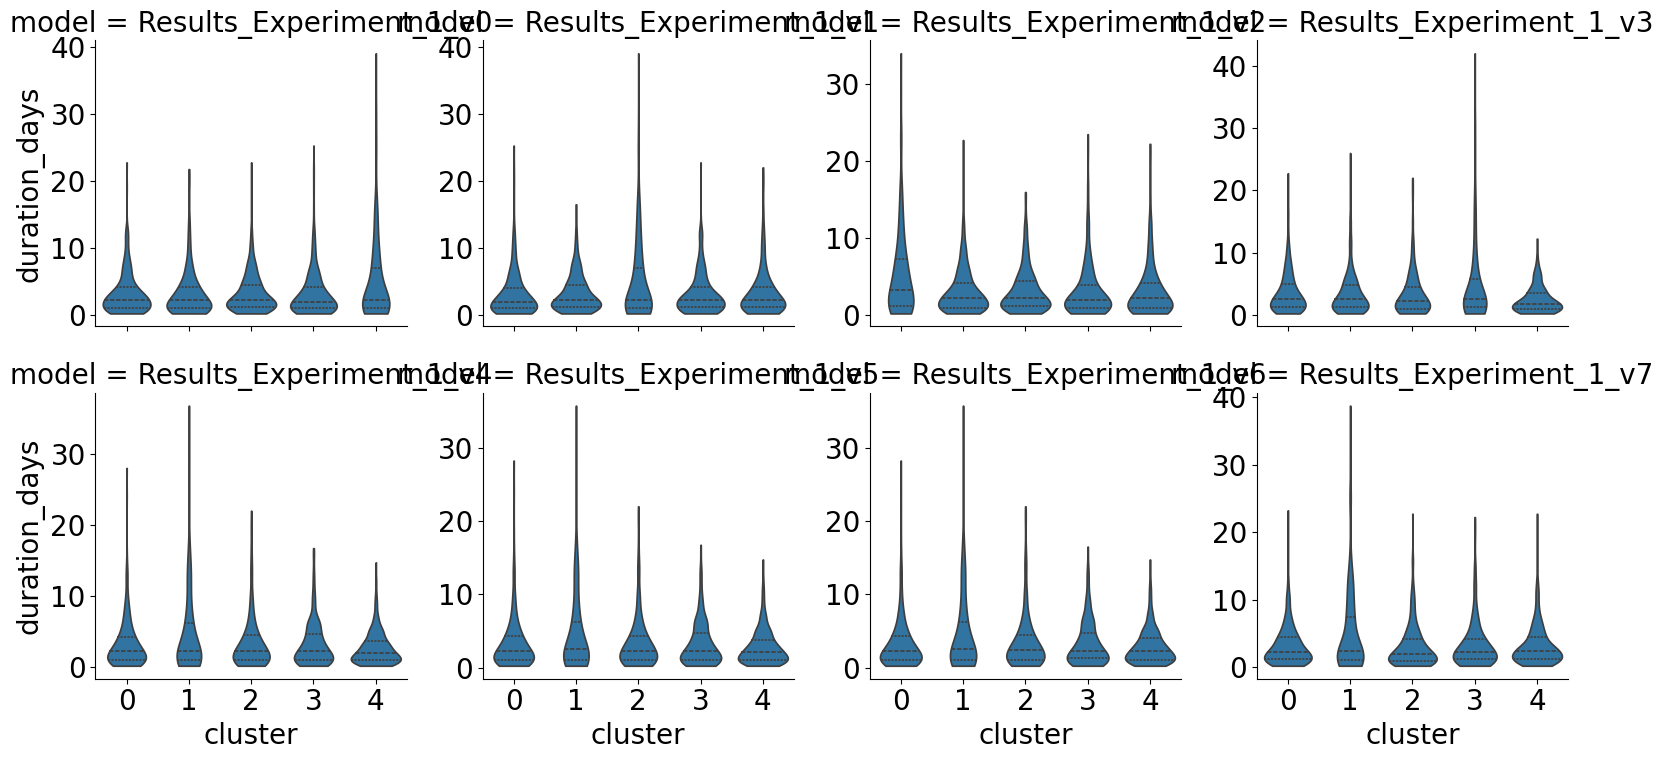

In [14]:
df = (outputs["models"][model_name]["cluster_labels"], outputs["raw"]["time"])
df = pd.DataFrame({
    "cluster": outputs["models"][model_name]["cluster_labels"],
    "time"   : outputs["raw"]["time"],
})


# 1) Feste Schrittweite von 6 h definieren
interval = pd.Timedelta(hours=6)

model_names = list(outputs["models"].keys())
all_runs = []

for model_name in model_names:
    # --- a) DataFrame mit cluster, time und model ---
    df = pd.DataFrame({
        "cluster": outputs["models"][model_name]["cluster_labels"],
        "time":    outputs["raw"]["time"]
    })
    df["time"] = pd.to_datetime(df["time"])
    df["model"] = model_name

    # --- b) Sortieren und Zeitdifferenzen berechnen ---
    df = df.sort_values("time").reset_index(drop=True)
    df["time_diff"] = df["time"].diff().fillna(interval)

    # --- c) Gaps markieren (länger als ein Schritt) ---
    df["is_gap"] = df["time_diff"] > interval

    # --- d) Neuer Run wenn Cluster wechselt OR ein Gap auftritt ---
    df["is_new_run"] = df["cluster"].ne(df["cluster"].shift(1)) | df["is_gap"]
    df["run_id"]     = df["is_new_run"].cumsum()

    # --- e) Runs aggregieren ---
    runs = (
        df
        .groupby("run_id", as_index=False)
        .agg(
            model        = ("model",   "first"),
            cluster      = ("cluster", "first"),
            count_steps  = ("time",    "size"),
        )
    )

    # --- f) Dauer in Tagen berechnen ---
    runs["duration_days"] = runs["count_steps"] * interval / pd.Timedelta(days=1)

    # --- g) Nur positive Läufe bis maximal 20 Tage behalten ---
    runs = runs[(runs["duration_days"] > 0) & (runs["duration_days"] <= 100)]

    all_runs.append(runs[["model","cluster","duration_days"]])

# 2) Alle Runs zusammenführen
df_runs = pd.concat(all_runs, ignore_index=True)

# 3) Plot mit Seaborn Catplot (Violin pro Modell und Cluster)
g = sns.catplot(
    data=df_runs,
    x="cluster", y="duration_days",
    col="model",
    kind="violin",
    inner="quartile",
    cut=0,
    sharey=False,
    height=4,
    col_wrap=4,
    aspect=1,
)
